# Probing Syntax in LLMs
by Lars Kulbe, Maxim Kurvink & Ole Jürgensen 

#### Import libraries

In [7]:
import os
import requests
import re
import sys
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx


import transformer_lens
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

from io import StringIO, BytesIO
from conllu import parse_incr
from IPython.display import Image, display
from PIL import Image as PILImage


## Introduction to Parsing Trees, Dataset, and Research Question

### Parsing Trees

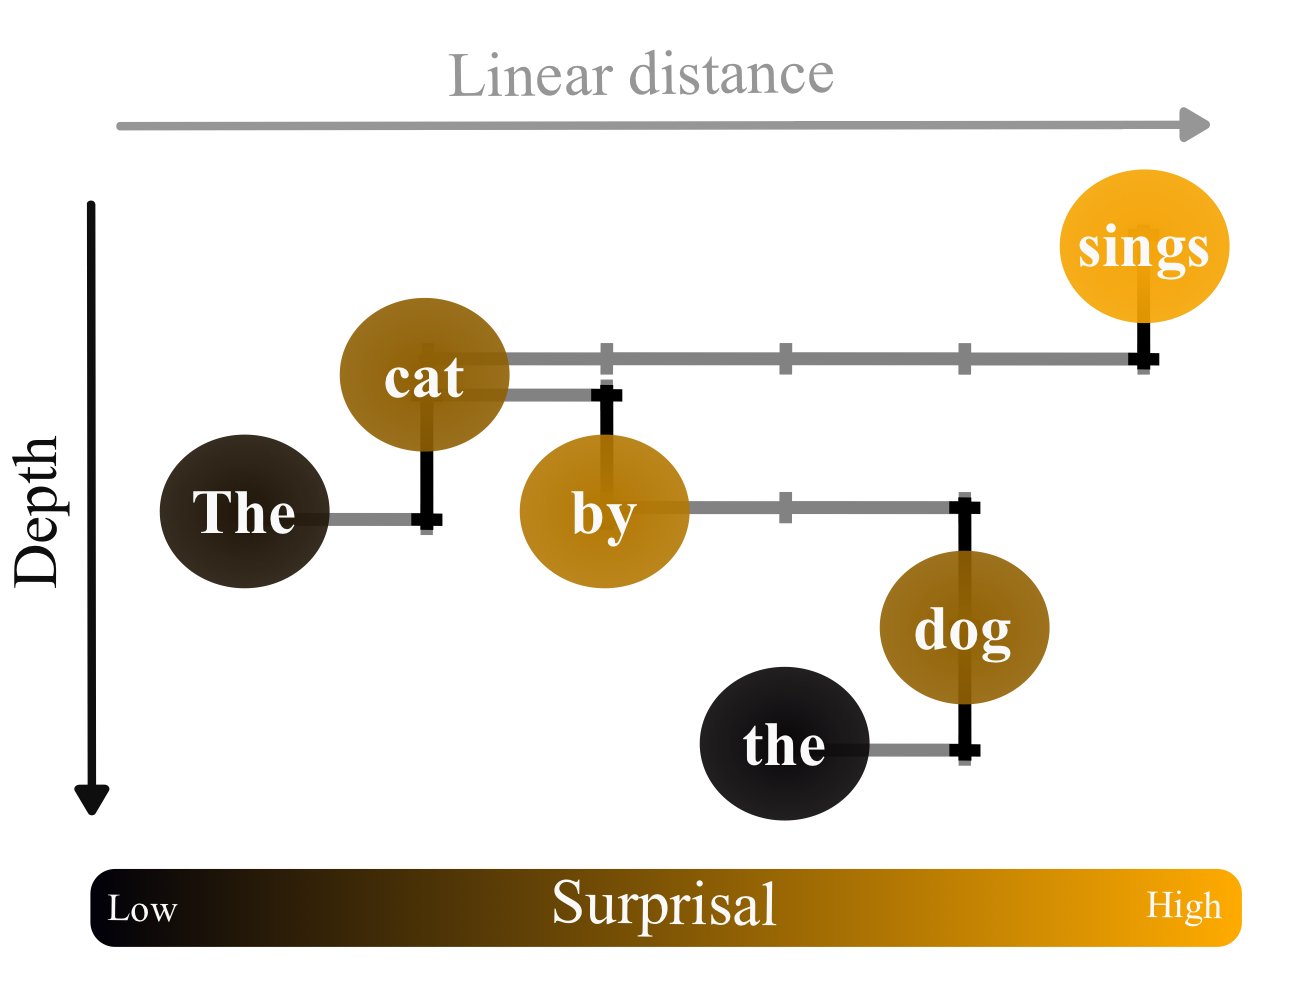

In [8]:
image_path = "images/tree_example.jpeg"
display(Image(filename=image_path, width=400, height=300))

The image adapted from Diego-Simon et al. (2025) depicts a typical **dependency-based parse** tree for a short sentence. Nodes in the tree represent words, and edges represent immediate dependencies. Nodes that connect to a lower-level node are referred to as that node’s **parent**, while the lower-level node is called the **child**. At the lowest depth, we find the **root** of the sentence (sings), which is the main verb of the sentence. The children of a node can be thought of as adding information to the parent. In this example, the prepositional phrase “by the dog” modifies the subject “cat.”

To construct these trees, we require hand-annoted sentences. We use the Universal Dependencies - English Dependency Treebank (v2.17 -- 2025-11-15) data, which is openly available on their GitHub repository.

In [145]:
def get_data():
    sentences_train = []
    sentences_test = []

    root_url = "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/"
    
    files = {
        "test": "en_ewt-ud-test.conllu", 
        "train": "en_ewt-ud-train.conllu"
        }

    for key, file in files.items():
        file_url = os.path.join(root_url, file)
        response = requests.get(file_url)
        response.raise_for_status()


        file_content = StringIO(response.text)
        for sentence in parse_incr(file_content):
            if key == "test":
                sentences_test.append(sentence)
            if key == "train":
                sentences_train.append(sentence)

    # exlude email addresses and URLs
    email_pattern = re.compile(r'\S+@\S+')
    url_pattern = re.compile(r'http\S+|www\S+')

    sentences_train = [s for s in sentences_train if not email_pattern.search(s.metadata["text"]) and not url_pattern.search(s.metadata["text"])]
    sentences_test =  [s for s in sentences_test  if not email_pattern.search(s.metadata["text"]) and not url_pattern.search(s.metadata["text"])]
    
    return sentences_train, sentences_test

sentences_train, sentences_test = get_data()
print("There are {} training sentences and {} test sentences.".format(len(sentences_train), len(sentences_test)))

There are 12279 training sentences and 2004 test sentences.


Print some example sentences:

In [139]:
for i in np.random.randint(0, len(sentences_train), size = 5):
    print(sentences_train[i].metadata["text"])

In this day and age, it is so rare to find a company with such nice workers and such far ranging guarantee policies.
In addition, could you look over the list below to see if there are any additional employees in your group that spent time on ECP, so we can ensure we bill all of our used resources to ECP.
It is pointless to try to understand the subtle differences between the Sunni terror of Al Qaeda and Hamas and the Shiite terror of Hezbollah, Sadr and other Iranian-inspired enterprises.
If you have received this email in error please notify the sender.
Do we have someone who is watching this out there?


The dependency tree structure can be described by a single variable (head), specifying the **parent** of a given word.

In [146]:
idx = 59
print(sentences_test[idx].metadata["text"])
print("")
for tok in sentences_test[idx]:
    print(str(tok['id']).ljust(3), tok['form'].ljust(12), ' --> ', sentences_test[idx][tok['head']-1]['form'] if tok['head'] != 0 else 'ROOT')

I had to go to the BBC for this report .

1   I             -->  had
2   had           -->  ROOT
3   to            -->  go
4   go            -->  had
5   to            -->  BBC
6   the           -->  BBC
7   BBC           -->  go
8   for           -->  report
9   this          -->  report
10  report        -->  go
11  .             -->  had


Based on this we can reconstruct the parse tree distances using the lowest common ancestor (LCA; not to be confused with Latent Class Analysis). Direct links have a distance of 1, if there is one node sperating, them the distance is 2, and so on.

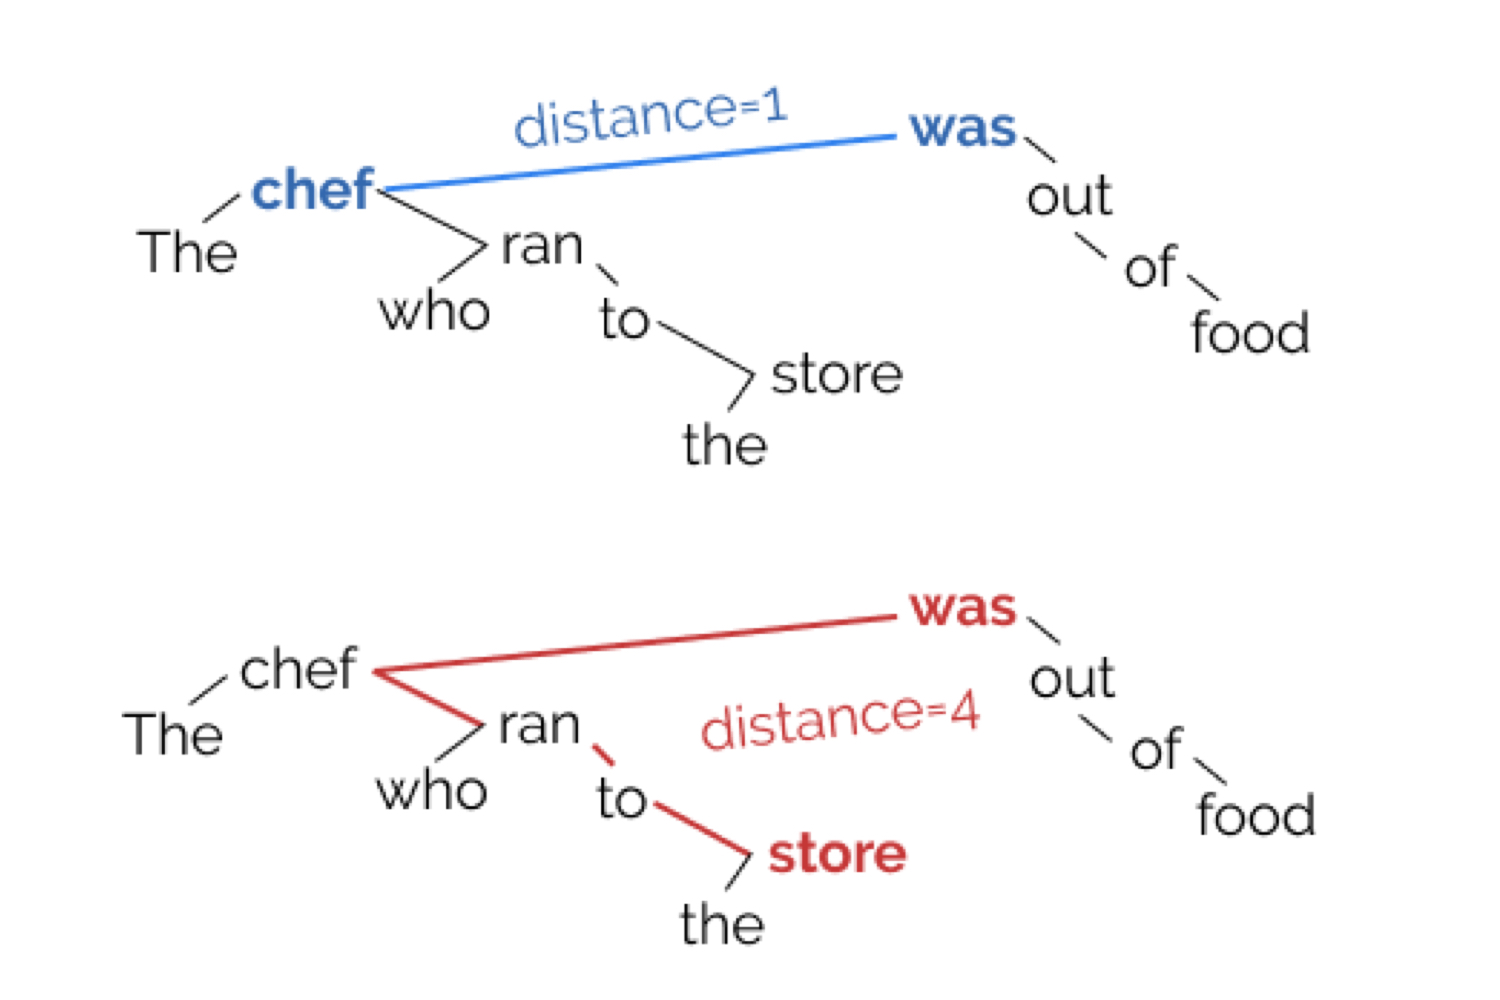

In [147]:
# example from Hewitt and Manning (2019)
image_path = "images/distance_scheme.jpeg"
display(Image(filename=image_path, width=400, height = 300))

### Define Functions

Below is a custom function to get syntactic tree distances from our annotated sentences

<Axes: >

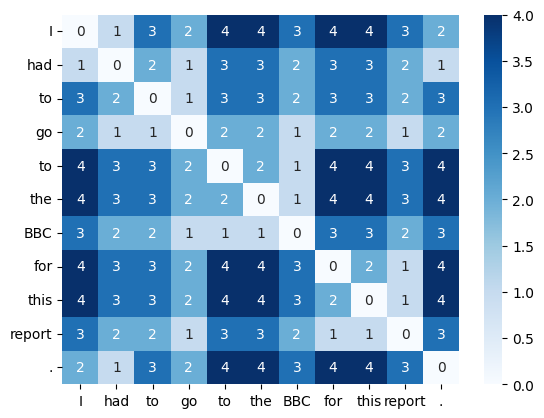

In [148]:
def distance_matrix_from_sentence(sentence):
    """
    Return (matrix, ids) where matrix[i,j] is the discrete tree distance
    (number of edges) between token ids[i] and ids[j].
    Expects tokens with integer 'id' and 'head' (head==0 means ROOT).
    """

    forms = [tok['form'] for tok in sentence]
    ids = [tok['id'] for tok in sentence if isinstance(tok['id'], int)]
    parent = {tok['id']: (tok['head'] if tok['head'] != 0 else None) for tok in sentence if isinstance(tok['id'], int)}
    
    # Find the root token's id (where head == 0)
    root_id = next(tok['id'] for tok in sentence if isinstance(tok['id'], int) and tok['head'] == 0)
    id_to_idx = {tid: idx for idx, tid in enumerate(ids)}
    root_idx = id_to_idx[root_id]

    def ancestors(n):
        path = [n]
        while parent.get(path[-1]) is not None:
            path.append(parent[path[-1]])
        return path  # from node up to root

    depths = {i: len(ancestors(i)) - 1 for i in ids}  # distance to root
    n = len(ids)
    mat = np.zeros((n, n), dtype=int)

    # compute pairwise distances via lowest common ancestor (LCA)
    for i, a in enumerate(ids):
        anc_a = ancestors(a)
        set_anc_a = set(anc_a)
        for j, b in enumerate(ids):
            if i == j:
                continue
            anc_b = ancestors(b)
            # find first common ancestor
            lca = next((x for x in anc_b if x in set_anc_a), None)
            mat[i, j] = depths[a] + depths[b] - 2 * depths[lca]

    root_dist = mat[root_idx, :]
    return mat, ids, root_dist, forms


mat, ids, root_dist, forms = distance_matrix_from_sentence(sentences_test[idx])
sns.heatmap(mat, xticklabels=forms, yticklabels=forms, cmap="Blues", annot=True)

We can transform the distance matrix into a dependency-based parse tree using the NetworkX library. We obtain the minimum spanning tree using Kruskal’s algorithm. Note that we manually set the node positions according to their order in the sentence (x-axis) and their distance from the root (i.e., depth; y-axis).

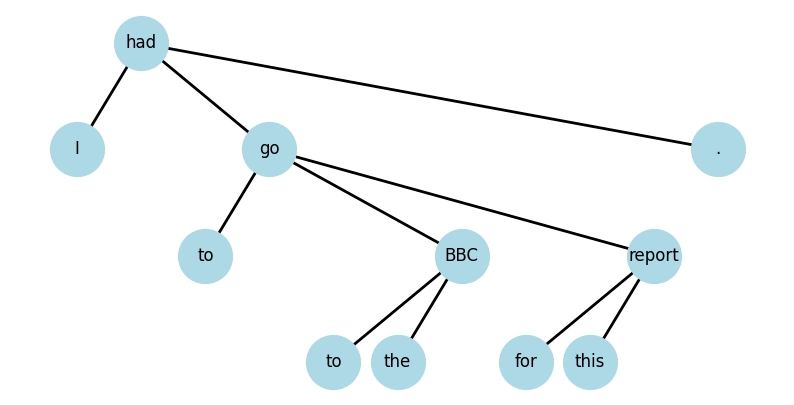

In [ ]:
def graph_from_distance_matrix(mat, ids, root_dist, forms, ax=None, node_size = 1500, font_size = 12, width = 2, plot = True):

    # Compute MST using Kruskal’s algorithm
    G = nx.from_numpy_array(mat)
    mst = nx.minimum_spanning_tree(G, algorithm="kruskal")
    adj_matrix = nx.to_numpy_array(mst)
    # Prepare node positions: x=ids, y=root_dist, to get a readable plot
    pos = {i: (id, len(root_dist) - root_dist[idx]) for idx, (i, id) in enumerate(zip(range(len(ids)), ids))}

    if plot:
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))
        nx.draw(
            mst,
            pos=pos,
            ax=ax,
            with_labels=True,
            labels={i: forms[i] for i in range(len(forms))},
            node_color='lightblue',
            edge_color='black',
            node_size=node_size,
            font_size=font_size,
            width=width,
        )
        ax.set_xlabel("ids")
        ax.set_ylabel("root_dist")

    return adj_matrix, ax

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
graph_from_distance_matrix(mat, ids, root_dist, forms, ax=axs)
plt.show()

Lets do this for some more sentences:

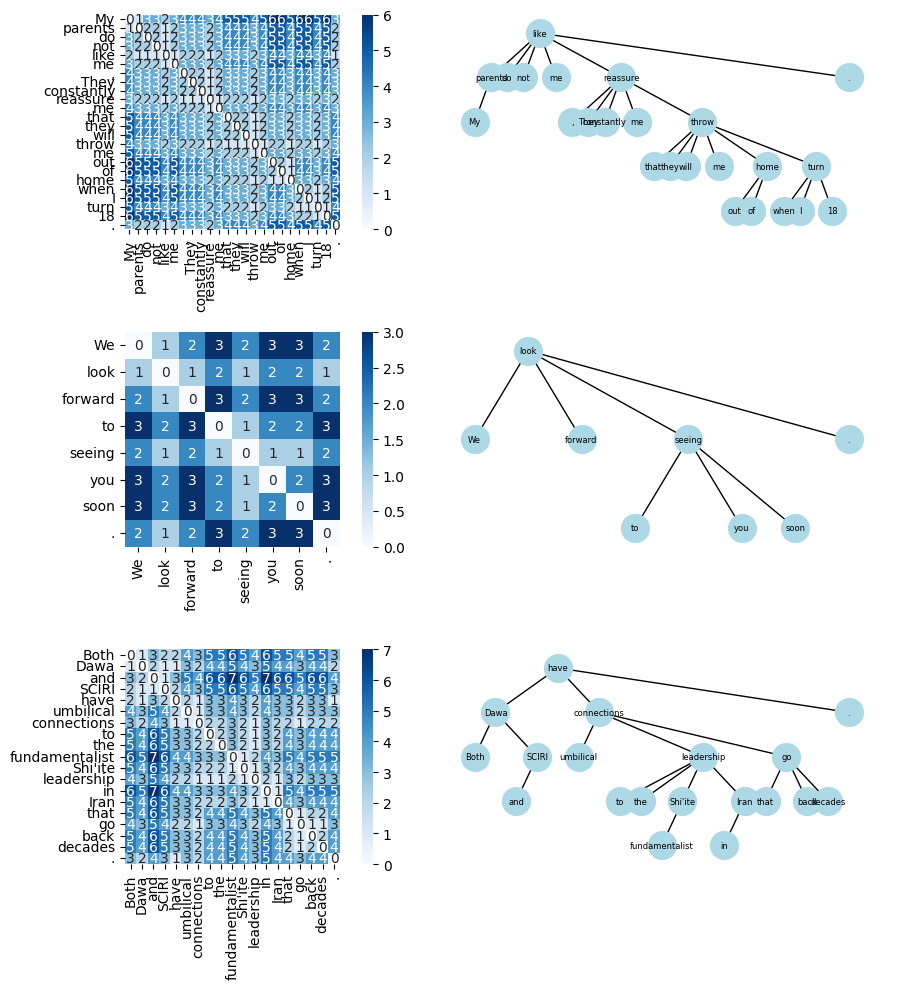

In [149]:
num_sentences = 3
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

np.random.seed(2) # note that the sentences can be quite long, if the seed is changed
for i, id in enumerate(np.random.randint(0, len(sentences_train), size = num_sentences)):
    mat, ids, root_dist, forms = distance_matrix_from_sentence(sentences_train[id])
    sns.heatmap(mat, xticklabels=forms, yticklabels=forms, cmap="Blues", annot=True, ax = axs[i, 0], square =True)
    graph_from_distance_matrix(mat, ids, root_dist, forms, ax=axs[i, 1], node_size = 400, font_size = 6, width = 1)
plt.tight_layout()

### Research Question

We evaluate whether parsing trees are embedded in the hidden layer of a large language model. However, se cannot decode the syntactic dependencies by looking at the raw embeddings, since these will also encode additional information, such as semantics or task relevant aspects for next-token prediction. Therefore, we will aim to extract the syntactic content using a **structural probe**, which maps the embeddings into a new, lower-dimensional structure (see figure below)

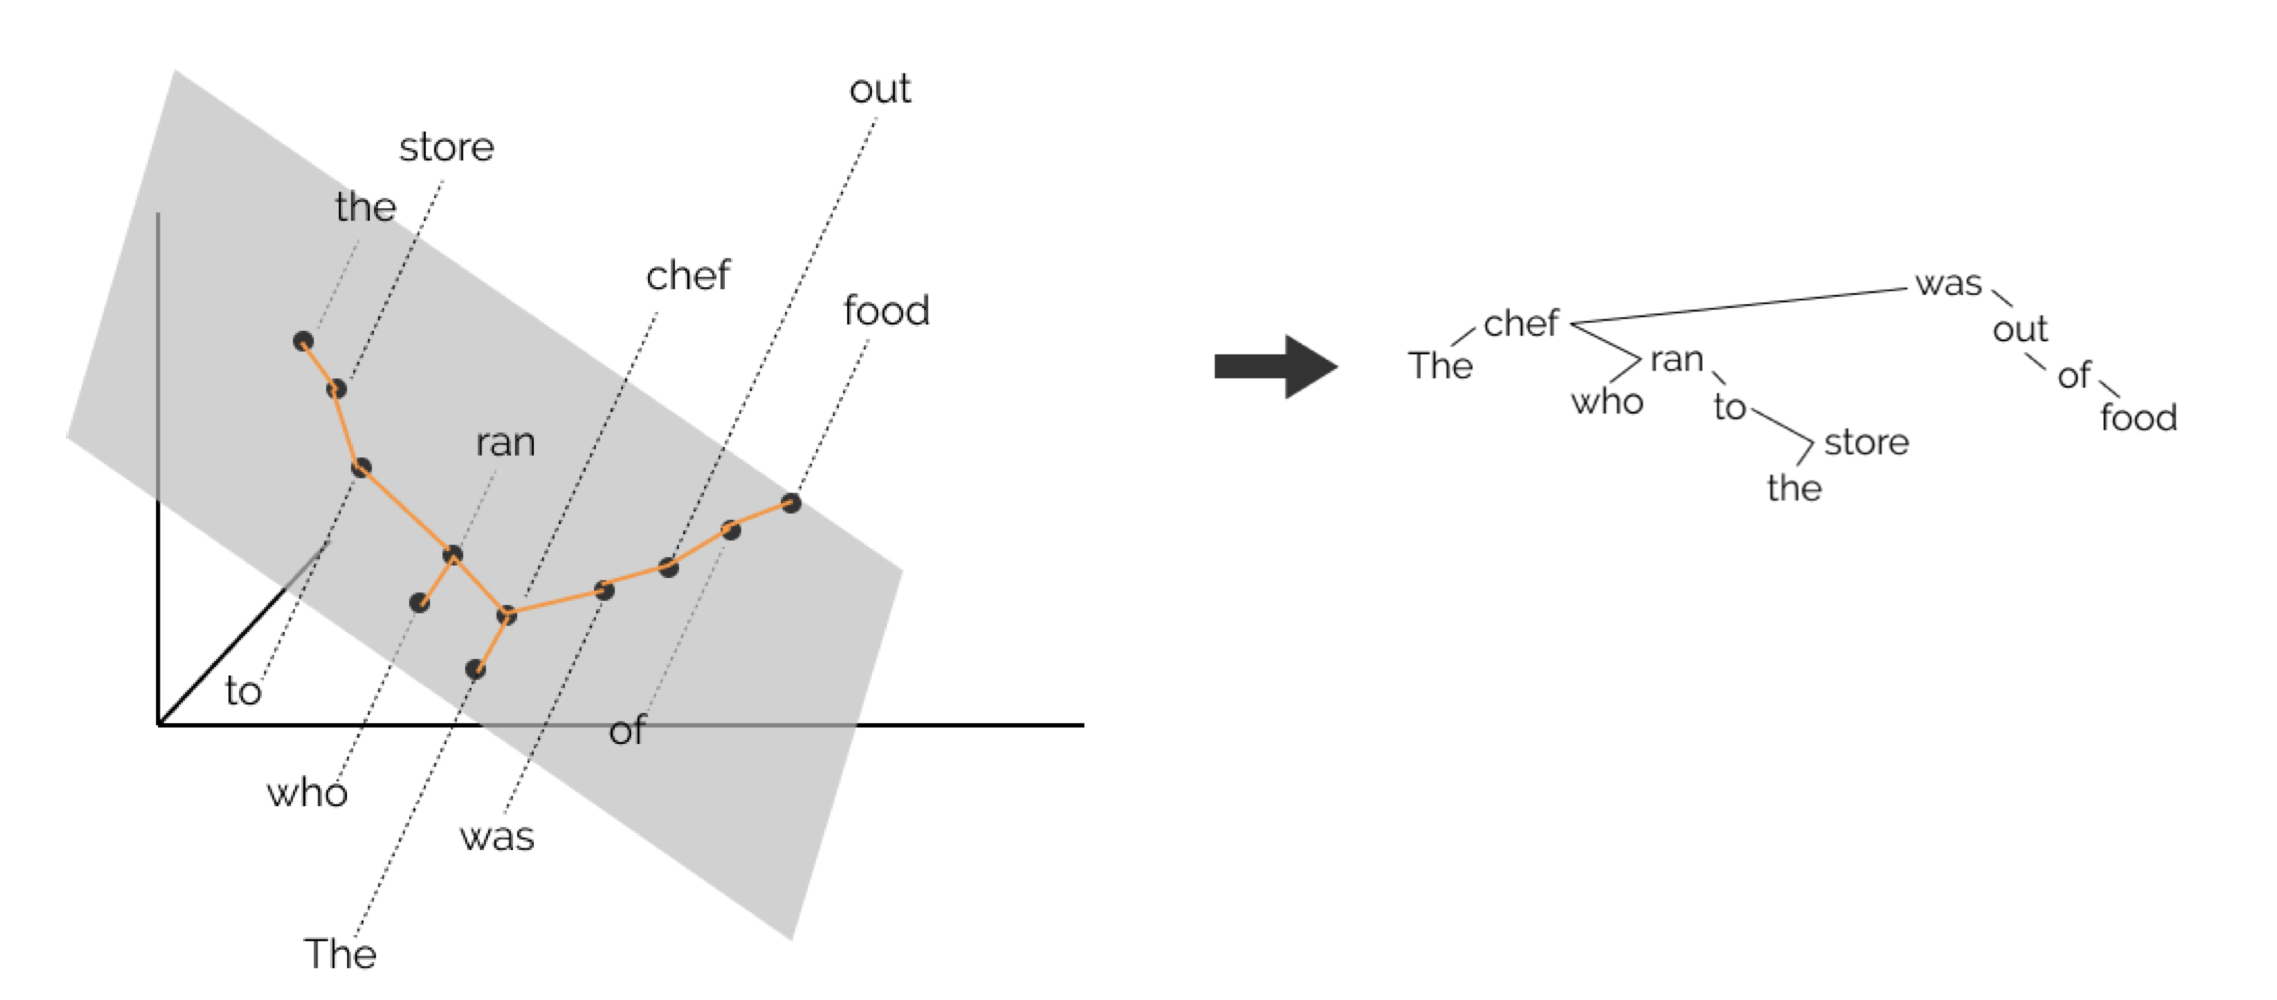

In [16]:
# from Hewitt and Manning (2019)
image_path = "images/probe_scheme.jpeg"
display(Image(filename=image_path, width=600, height=400))

The probe transforms the individual word embeddings (from the LLM) for each token in the sentence. Specifically, it projects each embedding into a lower-dimensional space (of a pre-determined size) using the learned probe matrix. Then, it computes pairwise distances between these projected embeddings to form the predicted syntactic distance matrix. Therefore, the only "deep" learning we do, is determining that projection matrices weights.

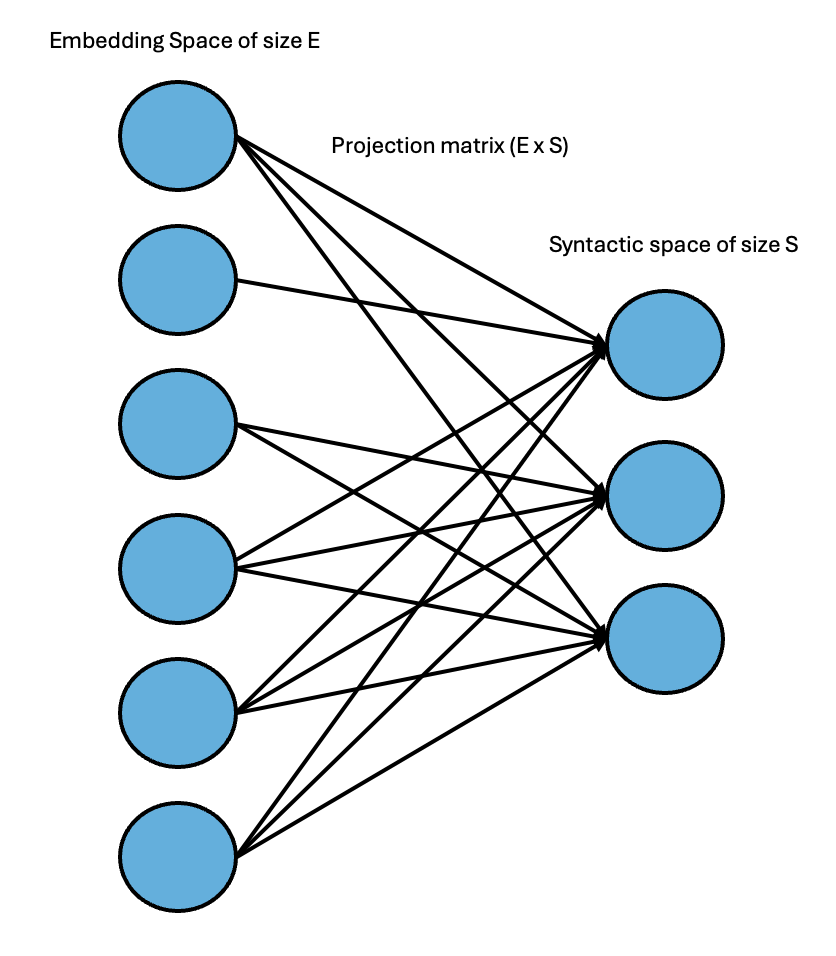

In [17]:
# add figure showing probe architecture
image_path = "images/mlp_scheme.png"
display(Image(filename=image_path, width=300, height=200))

Our projects unique contributions are...

## Implement Structural Probe

### Define functions to get embeddings and matrices

For the ground truth matrices, we just apply it to all our sentences in the for-loop. For the LLM-emeddings we need to ensure that the models tokenizer matches our annotations in the dataset. We do this by **pooling by the last sub-token**, which we found suitable for an autoregressive model like GPT-2. Alternatives that are implemented in the function, but not used, are pooling by the first sub-token, or averaging the embeddings.

In [18]:
def get_matrices(sentences):
    """function to get distance matrices for a list of sentences"""
    matrices = []
    for sent in sentences:
        mat, _, _, _ = distance_matrix_from_sentence(sent)
        matrices.append(mat)
    return matrices

In [ ]:
def combine_token_embeddings(text, word_list, model, layer_name, pooling="last"):
    tokenizer = model.tokenizer
    # Tokenize with HF for offsets
    encoding = tokenizer(
        text,
        return_offsets_mapping=True,
        return_tensors="pt",
        add_special_tokens=False,
    )

    offsets = encoding["offset_mapping"][0].tolist()

    # Get activations from TransformerLens
    _, cache = model.run_with_cache([text],prepend_bos=False)
    activations = cache[layer_name][0]

    assert activations.shape[0] == len(offsets), (activations.shape[0],len(offsets),)

    # Find word spans
    word_spans = []
    cursor = 0
    for word in word_list:
        match = re.search(re.escape(word), text[cursor:])
        if match is None:
            raise ValueError(f"Word '{word}' not found after position {cursor}")
        start = cursor + match.start()
        end = start + len(word)
        word_spans.append((start, end))
        cursor = end

    # Now we pool embeddings
    word_embeddings = []
    for (ws, we) in word_spans:
        token_idxs = [
            i for i, (ts, te) in enumerate(offsets)
            if ts < we and te > ws
        ]
        if not token_idxs:
            raise ValueError(
                f"No tokens aligned to '{text[ws:we]}' at span {(ws, we)}"
            )
        token_embs = activations[token_idxs]

        # mode of pooling
        if pooling == "last":
            word_emb = token_embs[-1]
        elif pooling == "first":
            word_emb = token_embs[0]
        elif pooling == "mean":
            word_emb = token_embs.mean(dim=0)

        word_embeddings.append(word_emb)

    return torch.stack(word_embeddings)

In [26]:
class SyntaxProbeDataset(Dataset):

    def __init__(self, sentences, model_name, layer_name):
        self.sentences = []
        self.activations = []
        self.matrices = []
        model = transformer_lens.HookedTransformer.from_pretrained(model_name)
        for sentence in tqdm(sentences, desc="Processing sentences"):
            text = sentence.metadata["text"]
            activations = combine_token_embeddings(text, [tok["form"] for tok in sentence], model, layer_name)
            activation = activations.cpu().numpy()
            mat, _, _, _ = distance_matrix_from_sentence(sentence)
                
            if activation.shape[0] > 0 and mat.shape[0] > 0:
                self.sentences.append(sentence)
                self.activations.append(activation)
                self.matrices.append(mat)

    def __len__(self):
        return len(self.sentences)
    def __getitem__(self, idx):
        return self.activations[idx], self.matrices[idx]

def custom_collate_fn(batch):
    """Function to pad activations and matrices in a batch to the same length."""
    # batch: list of (activation, matrix) tuples
    activations, matrices = zip(*batch)
    batch_size = len(activations)
    seq_lens = [a.shape[0] for a in activations]
    max_len = max(seq_lens)
    hidden_dim = activations[0].shape[1]

    # Pad activations
    padded_activations = np.zeros((batch_size, max_len, hidden_dim), dtype=np.float32)
    for i, act in enumerate(activations):
        padded_activations[i, :act.shape[0], :] = act

    # Pad matrices
    padded_matrices = np.full((batch_size, max_len, max_len), fill_value=-1, dtype=np.float32)
    for i, mat in enumerate(matrices):
        l = mat.shape[0]
        padded_matrices[i, :l, :l] = mat

    # Convert to torch tensors
    padded_activations = torch.tensor(padded_activations)
    padded_matrices = torch.tensor(padded_matrices)
    lengths = torch.tensor(seq_lens)

    return padded_activations, padded_matrices, lengths, None

### Load Data

In [25]:
mod = transformer_lens.HookedTransformer.from_pretrained("gpt2")
sentences_train, sentences_test = get_data()

# create val split
np.random.seed(9)
val_idx = np.random.choice(len(sentences_train), size=int(0.1 * len(sentences_train)), replace=False)
sentences_val = [sentences_train[i] for i in val_idx]
sentences_train = [sentences_train[i] for i in range(len(sentences_train)) if i not in val_idx]

# exclude sentences that cannot be matched to tokenization (potentially faulty annotationy or special characters)
# unfortunately, this takes some time to run as we need to extract activations for each sentence
faulty_indices = {}
for name, sentence_set in {"train": sentences_train, "val": sentences_val, "test": sentences_test}.items():
    skip_indices = []
    for i, sentence in tqdm(enumerate(sentence_set), desc=f"Checking {name} set"):
        try:
            _ = combine_token_embeddings(sentence.metadata['text'], 
                                        [tok['form'] for tok in sentence],
                                        mod,
                                        'blocks.8.hook_resid_post')
        except Exception as e:
            skip_indices.append(i)
    faulty_indices[name] = skip_indices

print(f"excluding faulty sentences from train {len(faulty_indices['train'])}, val {len(faulty_indices['val'])}, and test {len(faulty_indices['test'])} sets")

# delete faulty indices
sentences_train = [sentences_train[i] for i in range(len(sentences_train)) if i not in faulty_indices["train"]]
sentences_val = [sentences_val[i] for i in range(len(sentences_val)) if i not in faulty_indices["val"]]
sentences_test = [sentences_test[i] for i in range(len(sentences_test)) if i not in faulty_indices["test"]]
print(f"After exclusion, dataset sizes are - train: {len(sentences_train)}, val: {len(sentences_val)}, test: {len(sentences_test)}")

Loaded pretrained model gpt2 into HookedTransformer


Checking train set: 11052it [04:36, 39.97it/s]
Checking val set: 1227it [00:30, 40.18it/s]
Checking test set: 2004it [00:49, 40.59it/s]


excluding faulty sentences from train 2013, val 198, and test 301 sets
After exclusion, dataset sizes are - train: 9039, val: 1029, test: 1703


### Implement Probes and Regimen

The code in this section is adpated from https://github.com/john-hewitt/structural-probes. Some adjustments were made to suit our data and model structure.

In [27]:
class Probe(nn.Module):
  pass

class TwoWordPSDProbe(Probe):
  """ Computes squared L2 distance after projection by a matrix.

  For a batch of sentences, computes all n^2 pairs of distances
  for each sentence in the batch.
  """
  def __init__(self, args):
    print('Constructing TwoWordPSDProbe')
    super(TwoWordPSDProbe, self).__init__()
    self.args = args
    self.probe_rank = args['probe']['maximum_rank']
    self.model_dim = args['model']['hidden_dim']

    # Initialize projection matrix
    self.proj = nn.Parameter(data = torch.zeros(self.model_dim, self.probe_rank))
    nn.init.uniform_(self.proj, -0.05, 0.05)
    self.to(args['device'])

  def forward(self, batch):
    """ Computes all n^2 pairs of distances after projection
    for each sentence in a batch.

    Note that due to padding, some distances will be non-zero for pads.
    Computes (B(h_i-h_j))^T(B(h_i-h_j)) for all i,j

    Args:
      batch: a batch of word representations of the shape
        (batch_size, max_seq_len, representation_dim)
    Returns:
      A tensor of distances of shape (batch_size, max_seq_len, max_seq_len)
    """
    batch = batch.to(self.proj.device) # added

    transformed = torch.matmul(batch, self.proj)
    batchlen, seqlen, rank = transformed.size()
    transformed = transformed.unsqueeze(2)
    transformed = transformed.expand(-1, -1, seqlen, -1)
    transposed = transformed.transpose(1,2).to(self.proj.device)
    diffs = transformed - transposed
    squared_diffs = diffs.pow(2).to(self.proj.device)
    squared_distances = torch.sum(squared_diffs, -1)
    return squared_distances

In [28]:
class L1DistanceLoss(nn.Module):
  """Custom L1 loss for distance matrices."""
  def __init__(self, args):
    super(L1DistanceLoss, self).__init__()
    self.args = args
    self.word_pair_dims = (1,2)

  def forward(self, predictions, label_batch, length_batch):
    """ Computes L1 loss on distance matrices.

    Ignores all entries where label_batch=-1
    Normalizes first within sentences (by dividing by the square of the sentence length)
    and then across the batch.

    Args:
      predictions: A pytorch batch of predicted distances
      label_batch: A pytorch batch of true distances
      length_batch: A pytorch batch of sentence lengths

    Returns:
      A tuple of:
        batch_loss: average loss in the batch
        total_sents: number of sentences in the batch
    """
    device = predictions.device
    label_batch = label_batch.to(device)
    length_batch = length_batch.to(device)

    labels_1s = (label_batch != -1).float()
    predictions_masked = predictions * labels_1s
    labels_masked = label_batch * labels_1s
    total_sents = torch.sum((length_batch != 0)).float()
    squared_lengths = length_batch.pow(2).float()
    if total_sents > 0:
      loss_per_sent = torch.sum(torch.abs(predictions_masked - labels_masked), dim=self.word_pair_dims)
      normalized_loss_per_sent = loss_per_sent / squared_lengths
      batch_loss = torch.sum(normalized_loss_per_sent) / total_sents
    else:
      batch_loss = torch.tensor(0.0, device=self.args['device'])
    return batch_loss, total_sents


In [ ]:
class ProbeRegimen:
  """Basic regimen for training and running inference on probes.
  
  Tutorial help from:
  https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

  Attributes:
    optimizer: the optimizer used to train the probe
    scheduler: the scheduler used to set the optimizer base learning rate
  """

  def __init__(self, args):
    self.args = args
    self.max_epochs = args['probe_training']['epochs']
    self.params_path = os.path.join(args['reporting']['root'], args['probe']['params_path'])

  def set_optimizer(self, probe):
    """Sets the optimizer and scheduler for the training regimen.
  
    Args:
      probe: the probe PyTorch model the optimizer should act on.
    """
    self.optimizer = optim.Adam(probe.parameters(), lr=0.001)
    self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1,patience=0)

  def train_until_convergence(self, probe, model, loss, train_dataset, dev_dataset):
    """ Trains a probe until a convergence criterion is met.

    Trains until loss on the development set does not improve by more than epsilon
    for 5 straight epochs.

    Writes parameters of the probe to disk, at the location specified by config.

    Args:
      probe: An instance of probe.Probe, transforming model outputs to predictions
      model: An instance of model.Model, transforming inputs to word reprs
      loss: An instance of loss.Loss, computing loss between predictions and labels
      train_dataset: a torch.DataLoader object for iterating through training data
      dev_dataset: a torch.DataLoader object for iterating through dev data
    """
    self.set_optimizer(probe)
    min_dev_loss = sys.maxsize
    min_dev_loss_epoch = -1

    self.train_losses = []
    self.val_losses = []
    
    for epoch_index in tqdm(range(self.max_epochs), desc='[training]'):
      epoch_train_loss = 0
      epoch_dev_loss = 0
      epoch_train_epoch_count = 0
      epoch_dev_epoch_count = 0
      epoch_train_loss_count = 0
      epoch_dev_loss_count = 0
      for batch in tqdm(train_dataset, desc='[training batch]'):
        probe.train()
        self.optimizer.zero_grad()
        observation_batch, label_batch, length_batch, _ = batch
        word_representations = model(observation_batch)
        predictions = probe(word_representations)
        batch_loss, count = loss(predictions, label_batch, length_batch)
        batch_loss.backward()
        epoch_train_loss += batch_loss.detach().cpu().numpy()*count.detach().cpu().numpy()
        epoch_train_epoch_count += 1
        epoch_train_loss_count += count.detach().cpu().numpy()
        self.optimizer.step()
      for batch in tqdm(dev_dataset, desc='[dev batch]'):
        self.optimizer.zero_grad()
        probe.eval()
        observation_batch, label_batch, length_batch, _ = batch
        word_representations = model(observation_batch)
        predictions = probe(word_representations)
        batch_loss, count = loss(predictions, label_batch, length_batch)
        epoch_dev_loss += batch_loss.detach().cpu().numpy()*count.detach().cpu().numpy()
        epoch_dev_loss_count += count.detach().cpu().numpy()
        epoch_dev_epoch_count += 1


      # Compute average losses and store them
      avg_train_loss = epoch_train_loss / epoch_train_loss_count
      avg_dev_loss = epoch_dev_loss / epoch_dev_loss_count
      self.train_losses.append(avg_train_loss)
      self.val_losses.append(avg_dev_loss)
        
      self.scheduler.step(epoch_dev_loss)
      tqdm.write('[epoch {}] Train loss: {}, Dev loss: {}'.format(epoch_index, epoch_train_loss/epoch_train_loss_count, epoch_dev_loss/epoch_dev_loss_count))
      if epoch_dev_loss / epoch_dev_loss_count < min_dev_loss - 0.0001:
        torch.save(probe.state_dict(), self.params_path)
        min_dev_loss = epoch_dev_loss / epoch_dev_loss_count
        min_dev_loss_epoch = epoch_index
        tqdm.write('Saving probe parameters')
      elif min_dev_loss_epoch < epoch_index - 4:
        tqdm.write('Early stopping')
        break

  def predict(self, probe, model, dataset):
    """ Runs probe to compute predictions on a dataset.

    Args:
      probe: An instance of probe.Probe, transforming model outputs to predictions
      model: An instance of model.Model, transforming inputs to word reprs
      dataset: A pytorch.DataLoader object 

    Returns:
      A list of predictions for each batch in the batches yielded by the dataset
    """
    probe.eval()
    predictions_by_batch = []
    for batch in tqdm(dataset, desc='[predicting]'):
      observation_batch, label_batch, length_batch, _ = batch
      word_representations = model(observation_batch)
      predictions = probe(word_representations)
      predictions_by_batch.append(predictions.detach().cpu().numpy())
    return predictions_by_batch

## Application to Example layer

### Train Model

In [30]:
# this cell may take around 5-10 minutes to run, since all activations are being extracted and transformed to match data sequentially
# rank of probe and epoch was determined via validation set performance

layer = 'blocks.8.hook_resid_post'

args = {
    'probe': {'maximum_rank': 64, 'params_path': f'probe_params/{layer}_probe_params.pt'},
    'model': {'hidden_dim': 768},
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'probe_training': {'epochs': 50},
    'reporting': {'root': './'}
}
probe = TwoWordPSDProbe(args)
loss_fn = L1DistanceLoss(args)
regimen = ProbeRegimen(args)

dataset = SyntaxProbeDataset(sentences_train, 'gpt2-small', layer)
dataloader = DataLoader(dataset, batch_size=32, collate_fn=custom_collate_fn)

val_dataset = SyntaxProbeDataset(sentences_val, 'gpt2-small', layer)
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=custom_collate_fn)

# we use this as the original code assumes feature extraction inside the regimen, while we do so with our custom functions in advance
class IdentityModel(nn.Module):
    def forward(self, x):
        return x
model = IdentityModel()

Constructing TwoWordPSDProbe
Loaded pretrained model gpt2-small into HookedTransformer


Processing sentences:   1%|          | 105/9039 [00:02<03:36, 41.21it/s]

Processing sentences: 100%|██████████| 9039/9039 [03:50<00:00, 39.25it/s]


Loaded pretrained model gpt2-small into HookedTransformer


Processing sentences: 100%|██████████| 1029/1029 [00:26<00:00, 38.96it/s]


In [31]:
# model training may also take about 10 minutes
regimen.train_until_convergence(
    probe=probe,
    model=model,
    loss=loss_fn,
    train_dataset=dataloader,
    dev_dataset=val_dataloader
)

[training]:   2%|▏         | 1/50 [00:01<01:17,  1.58s/it]

[epoch 0] Train loss: 1096.0486646488264, Dev loss: 101.62708011845922
Saving probe parameters


[training]:   4%|▍         | 2/50 [00:02<01:09,  1.44s/it]

[epoch 1] Train loss: 61.85474963039935, Dev loss: 36.76759203437234
Saving probe parameters


[training]:   6%|▌         | 3/50 [00:04<01:07,  1.43s/it]

[epoch 2] Train loss: 23.858757706946115, Dev loss: 15.122760272234592
Saving probe parameters


[training]:   8%|▊         | 4/50 [00:05<01:05,  1.43s/it]

[epoch 3] Train loss: 9.91878528934702, Dev loss: 6.251306494887994
Saving probe parameters


[training]:  10%|█         | 5/50 [00:07<01:03,  1.41s/it]

[epoch 4] Train loss: 4.078727875363578, Dev loss: 2.6102335163409323
Saving probe parameters


[training]:  12%|█▏        | 6/50 [00:08<01:02,  1.41s/it]

[epoch 5] Train loss: 2.0080713512016777, Dev loss: 1.5808187082511227
Saving probe parameters


[training]:  14%|█▍        | 7/50 [00:09<00:59,  1.39s/it]

[epoch 6] Train loss: 1.5607465179980178, Dev loss: 2.1183198441337683


[training]:  16%|█▌        | 8/50 [00:11<00:57,  1.38s/it]

[epoch 7] Train loss: 1.0642869875275174, Dev loss: 1.0918835592686955
Saving probe parameters


[training]:  18%|█▊        | 9/50 [00:12<00:55,  1.36s/it]

[epoch 8] Train loss: 1.0157591733986304, Dev loss: 1.0665100475789506
Saving probe parameters


[training]:  20%|██        | 10/50 [00:14<00:55,  1.39s/it]

[epoch 9] Train loss: 0.9895973479883612, Dev loss: 1.0362779294784146
Saving probe parameters


[training]:  22%|██▏       | 11/50 [00:15<00:53,  1.36s/it]

[epoch 10] Train loss: 0.9644860634696683, Dev loss: 1.0083303497877947
Saving probe parameters


[training]:  24%|██▍       | 12/50 [00:16<00:52,  1.38s/it]

[epoch 11] Train loss: 0.940547586186347, Dev loss: 0.9833033351323579
Saving probe parameters


[training]:  26%|██▌       | 13/50 [00:18<00:52,  1.41s/it]

[epoch 12] Train loss: 0.9148580539752746, Dev loss: 0.9568537479471071
Saving probe parameters


[training]:  28%|██▊       | 14/50 [00:19<00:49,  1.38s/it]

[epoch 13] Train loss: 0.8901142675748163, Dev loss: 0.9351048432471569
Saving probe parameters


[training]:  30%|███       | 15/50 [00:20<00:48,  1.38s/it]

[epoch 14] Train loss: 0.8694155841079984, Dev loss: 0.9280549119814029
Saving probe parameters


[training]:  32%|███▏      | 16/50 [00:22<00:46,  1.36s/it]

[epoch 15] Train loss: 0.8500895540803153, Dev loss: 0.8942058102614214
Saving probe parameters


[training]:  34%|███▍      | 17/50 [00:23<00:45,  1.38s/it]

[epoch 16] Train loss: 0.8269839048886777, Dev loss: 0.882928442329429
Saving probe parameters


[training]:  36%|███▌      | 18/50 [00:24<00:43,  1.36s/it]

[epoch 17] Train loss: 0.8077547529363859, Dev loss: 0.8576681078696737
Saving probe parameters


[training]:  38%|███▊      | 19/50 [00:26<00:42,  1.37s/it]

[epoch 18] Train loss: 0.7878340820201085, Dev loss: 0.8227150437899071
Saving probe parameters


[training]:  40%|████      | 20/50 [00:27<00:40,  1.36s/it]

[epoch 19] Train loss: 0.7701013081632154, Dev loss: 0.8014147733460363
Saving probe parameters


[training]:  42%|████▏     | 21/50 [00:29<00:39,  1.38s/it]

[epoch 20] Train loss: 0.75645775884136, Dev loss: 0.782511882578087
Saving probe parameters


[training]:  44%|████▍     | 22/50 [00:30<00:38,  1.36s/it]

[epoch 21] Train loss: 0.7396453819861519, Dev loss: 0.7711172507038617
Saving probe parameters


[training]:  46%|████▌     | 23/50 [00:31<00:37,  1.38s/it]

[epoch 22] Train loss: 0.7306437994054572, Dev loss: 0.7564777577236165
Saving probe parameters


[training]:  48%|████▊     | 24/50 [00:33<00:36,  1.39s/it]

[epoch 23] Train loss: 0.7153735284797912, Dev loss: 0.7459059521570381
Saving probe parameters


[training]:  50%|█████     | 25/50 [00:34<00:34,  1.37s/it]

[epoch 24] Train loss: 0.7084226821399735, Dev loss: 0.7456056828401527
Saving probe parameters


[training]:  52%|█████▏    | 26/50 [00:36<00:33,  1.39s/it]

[epoch 25] Train loss: 0.6988656803337474, Dev loss: 0.7223431691020524
Saving probe parameters


[training]:  54%|█████▍    | 27/50 [00:37<00:31,  1.38s/it]

[epoch 26] Train loss: 0.7024139805644048, Dev loss: 0.7146087241937398
Saving probe parameters


[training]:  56%|█████▌    | 28/50 [00:38<00:31,  1.44s/it]

[epoch 27] Train loss: 0.68846615690984, Dev loss: 0.7039633747208338
Saving probe parameters


[training]:  58%|█████▊    | 29/50 [00:40<00:29,  1.43s/it]

[epoch 28] Train loss: 0.6738594986588201, Dev loss: 0.6993964466803044
Saving probe parameters


[training]:  60%|██████    | 30/50 [00:41<00:28,  1.41s/it]

[epoch 29] Train loss: 0.6737622723060842, Dev loss: 0.7122542855806786


[training]:  62%|██████▏   | 31/50 [00:43<00:29,  1.53s/it]

[epoch 30] Train loss: 0.6165622399304079, Dev loss: 0.6830840727098945
Saving probe parameters


[training]:  64%|██████▍   | 32/50 [00:44<00:26,  1.48s/it]

[epoch 31] Train loss: 0.6075179987030755, Dev loss: 0.6804980684879106
Saving probe parameters


[training]:  66%|██████▌   | 33/50 [00:46<00:25,  1.51s/it]

[epoch 32] Train loss: 0.6037368812396445, Dev loss: 0.6812615628608577


[training]:  68%|██████▊   | 34/50 [00:47<00:23,  1.50s/it]

[epoch 33] Train loss: 0.595288197014867, Dev loss: 0.6671943275295958
Saving probe parameters


[training]:  70%|███████   | 35/50 [00:49<00:21,  1.47s/it]

[epoch 34] Train loss: 0.5935607705051386, Dev loss: 0.6667820274308541
Saving probe parameters


[training]:  72%|███████▏  | 36/50 [00:50<00:20,  1.44s/it]

[epoch 35] Train loss: 0.5930273930891147, Dev loss: 0.6665309395340604
Saving probe parameters


[training]:  74%|███████▍  | 37/50 [00:53<00:22,  1.74s/it]

[epoch 36] Train loss: 0.592555688933364, Dev loss: 0.6662030155155935
Saving probe parameters


[training]:  76%|███████▌  | 38/50 [00:54<00:19,  1.62s/it]

[epoch 37] Train loss: 0.5921196954969628, Dev loss: 0.6658674539931199
Saving probe parameters


[training]:  78%|███████▊  | 39/50 [00:55<00:17,  1.56s/it]

[epoch 38] Train loss: 0.5916702856808086, Dev loss: 0.6657497996375674
Saving probe parameters


[training]:  80%|████████  | 40/50 [00:57<00:15,  1.51s/it]

[epoch 39] Train loss: 0.5912159629490065, Dev loss: 0.6654448576409105
Saving probe parameters


[training]:  82%|████████▏ | 41/50 [00:58<00:13,  1.47s/it]

[epoch 40] Train loss: 0.5908518843002479, Dev loss: 0.6654323994012801


[training]:  84%|████████▍ | 42/50 [01:00<00:12,  1.51s/it]

[epoch 41] Train loss: 0.5902560967657337, Dev loss: 0.6638801364324067
Saving probe parameters


[training]:  86%|████████▌ | 43/50 [01:01<00:10,  1.46s/it]

[epoch 42] Train loss: 0.5897661219762613, Dev loss: 0.6636483620624153
Saving probe parameters


[training]:  88%|████████▊ | 44/50 [01:03<00:09,  1.54s/it]

[epoch 43] Train loss: 0.5895858871315628, Dev loss: 0.6635832480716983


[training]:  90%|█████████ | 45/50 [01:04<00:07,  1.55s/it]

[epoch 44] Train loss: 0.5893416403141521, Dev loss: 0.6635608300059831


[training]:  92%|█████████▏| 46/50 [01:06<00:05,  1.49s/it]

[epoch 45] Train loss: 0.5893257150925396, Dev loss: 0.6635395273406953
Saving probe parameters


[training]:  94%|█████████▍| 47/50 [01:07<00:04,  1.49s/it]

[epoch 46] Train loss: 0.5893105227198929, Dev loss: 0.6635186391854541


[training]:  96%|█████████▌| 48/50 [01:09<00:02,  1.44s/it]

[epoch 47] Train loss: 0.5892959459256065, Dev loss: 0.6634993650475327


[training]:  98%|█████████▊| 49/50 [01:10<00:01,  1.42s/it]

[epoch 48] Train loss: 0.5892820236943757, Dev loss: 0.6634818953837551


[training]: 100%|██████████| 50/50 [01:11<00:00,  1.44s/it]

[epoch 49] Train loss: 0.5892686767379772, Dev loss: 0.6634672978644932


### Loading pre-trained probe parameters

In the probe_params folder, we have trained model parameters for a number of layers. Paramaters for a given layer can be loaded using the cell below.

In [140]:
# Set up args as in training
layer = 'blocks.8.hook_resid_post'
args = {
    'probe': {'maximum_rank': 64, 'params_path': f'probe_params/{layer}_probe_params.pt'},
    'model': {'hidden_dim': 768},
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'probe_training': {'epochs': 20},
    'reporting': {'root': './'}
}
# Load probe and parameters
probe_test = TwoWordPSDProbe(args)
state_dict = torch.load(args['probe']['params_path'], map_location=args['device'])
probe_test.load_state_dict(state_dict)
probe_test.eval()

Constructing TwoWordPSDProbe


TwoWordPSDProbe()

In [ ]:
# evaluate on test sentences
novel_sentences = sentences_test
novel_dataset = SyntaxProbeDataset(novel_sentences, 'gpt2-small', layer)
novel_dataloader = DataLoader(novel_dataset, batch_size=100, collate_fn=custom_collate_fn)
model = IdentityModel()

predictions = regimen.predict(probe_test, model, novel_dataloader)

Loaded pretrained model gpt2-small into HookedTransformer


[predicting]: 100%|██████████| 21/21 [00:01<00:00, 19.31it/s]


## Model Evaluation

### Loss Curves

First, we take a look at the loss curves. Loss is decreasing over epochs which means that the model successfully learns a pattern and converges on a set of parameters. Moreover, there os no evidence of overfitting, which is plausible, hiven the relatively low flexibility of our model.

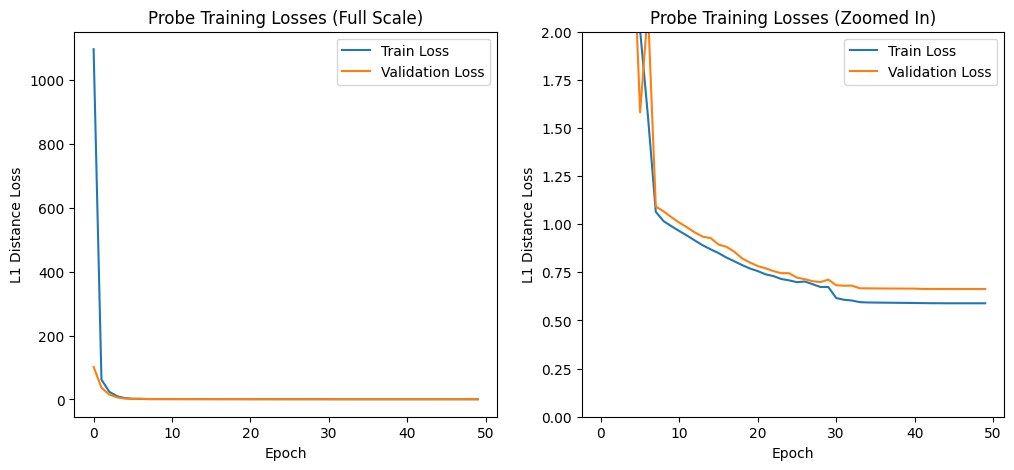

In [32]:
# loss function plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(regimen.train_losses, label='Train Loss')
ax[0].plot(regimen.val_losses, label='Validation Loss')
ax[0].set_title('Probe Training Losses (Full Scale)')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('L1 Distance Loss')
ax[0].legend()

ax[1].plot(regimen.train_losses, label='Train Loss')
ax[1].plot(regimen.val_losses, label='Validation Loss')
ax[1].set_title('Probe Training Losses (Zoomed In)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('L1 Distance Loss')
ax[1].set_ylim(0, 2)
ax[1].legend()

### Test Set Performance

Loss curves are nice, but not very interpretable. So next we apply our model on some previously unseen sentences (the test set).

In [33]:
# Prepare new sentences as a SyntaxProbeDataset and DataLoader
novel_sentences = sentences_test
novel_dataset = SyntaxProbeDataset(novel_sentences, 'gpt2-small', layer)
novel_dataloader = DataLoader(novel_dataset, batch_size = 100, collate_fn=custom_collate_fn)

# Make predictions
predictions = regimen.predict(probe, model, novel_dataloader)

Loaded pretrained model gpt2-small into HookedTransformer


[predicting]: 100%|██████████| 18/18 [00:00<00:00, 94.70it/s]


To contextualize our model’s performance, we require a baseline measure. We therefore use a simple **linear distance matrix** as a baseline, which assumes that each word is the parent of the subsequent word in the sequence. Comparing our model against this baseline allows us to assess whether it captures genuine syntactic structure or merely learns a sequential heuristic.

In [ ]:
# generate linear baseline
def create_linear_baseline(test_sentences):
    baseline_matrices = []
    for sentence_idx, sentence in enumerate(test_sentences):

        mat, _, _, _ = distance_matrix_from_sentence(sentence)
        n = mat.shape[0]
        baseline_mat = np.zeros((n, n), dtype=int)
        for i in range(n):
            for j in range(n):
                baseline_mat[i, j] = abs(i - j)
        baseline_matrices.append(baseline_mat)
    return baseline_matrices
baseline_mats = [[mat] for mat in create_linear_baseline(novel_sentences)]

First, we look at predicted matrices and trees for a few example sentences.

you can buy me dinner when we get back.


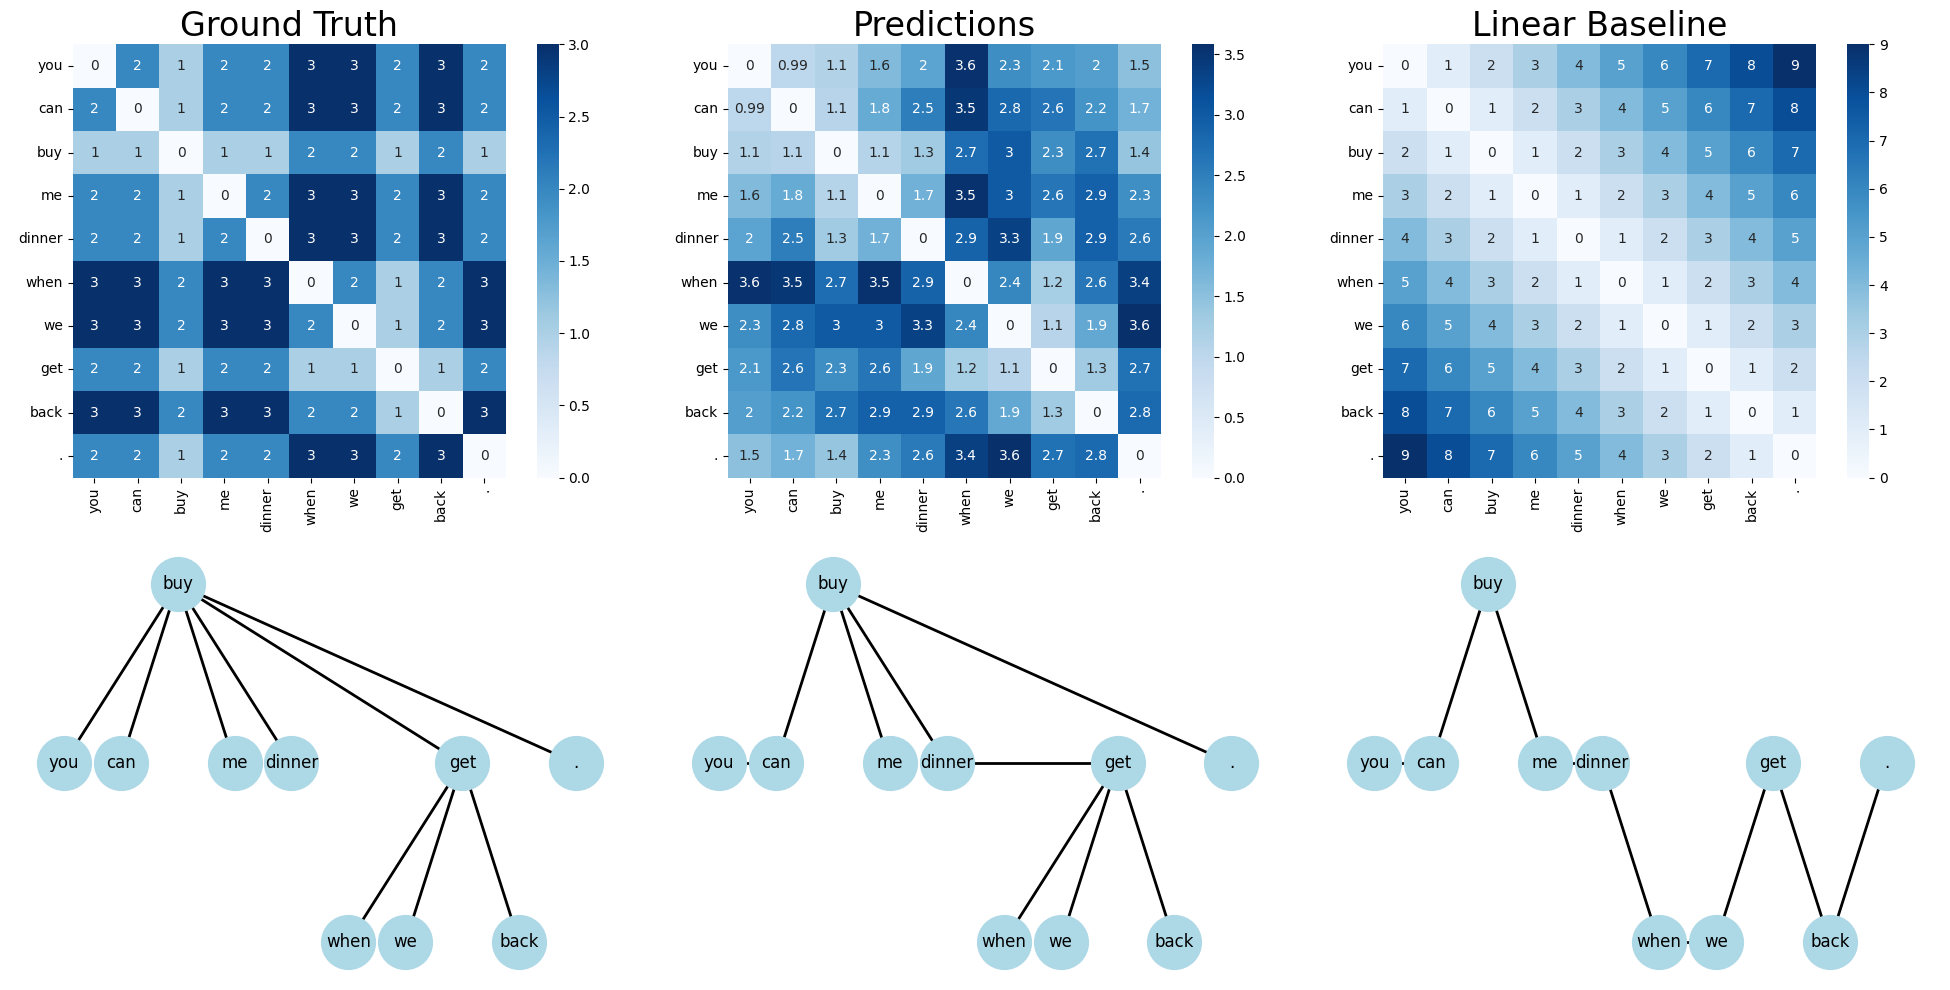

In [64]:
sentence_idx = 208
batch_size = 100
batch_id = sentence_idx // batch_size
idx_in_batch = sentence_idx % batch_size

mat, ids, root_dist, forms = distance_matrix_from_sentence(sentences_test[sentence_idx])
sentence = novel_sentences[sentence_idx]
print(sentence.metadata["text"])

fig, ax = plt.subplots(2, 3, figsize=(20, 10))
sns.heatmap(mat, cmap = "Blues", square = True, annot = True if len(sentence) <= 20 else False, xticklabels=forms, yticklabels=forms, ax = ax[0, 0])
# pred mat
sns.heatmap(predictions[batch_id][idx_in_batch][:len(sentence), :len(sentence)],square=True,
            cmap = "Blues", annot = True if len(sentence) <= 20 else False, xticklabels=forms, yticklabels=forms, 
            ax = ax[0, 1])
# baseline mat
sns.heatmap(baseline_mats[sentence_idx][0],square=True,
            cmap = "Blues", annot = True if len(sentence) <= 20 else False, xticklabels=forms, yticklabels=forms, 
            ax = ax[0, 2])

# true graph
graph_from_distance_matrix(mat, ids, root_dist, forms, ax=ax[1, 0])
# pred graph
graph_from_distance_matrix(predictions[batch_id][idx_in_batch][:len(sentence), :len(sentence)], ids, root_dist, forms, ax=ax[1, 1])
# baseline graph
graph_from_distance_matrix(baseline_mats[sentence_idx][0], ids, root_dist, forms, ax=ax[1, 2])

ax[0, 0].set_title("Ground Truth", size = 24)
ax[0, 1].set_title("Predictions", size = 24)
ax[0, 2].set_title("Linear Baseline", size = 24)
plt.tight_layout()

plt.show()

If you own a Retail Store or are a Professional Vendor who exhibits at Sport, Hunting, or Craft Shows and are interested in selling our products,please give us a call!


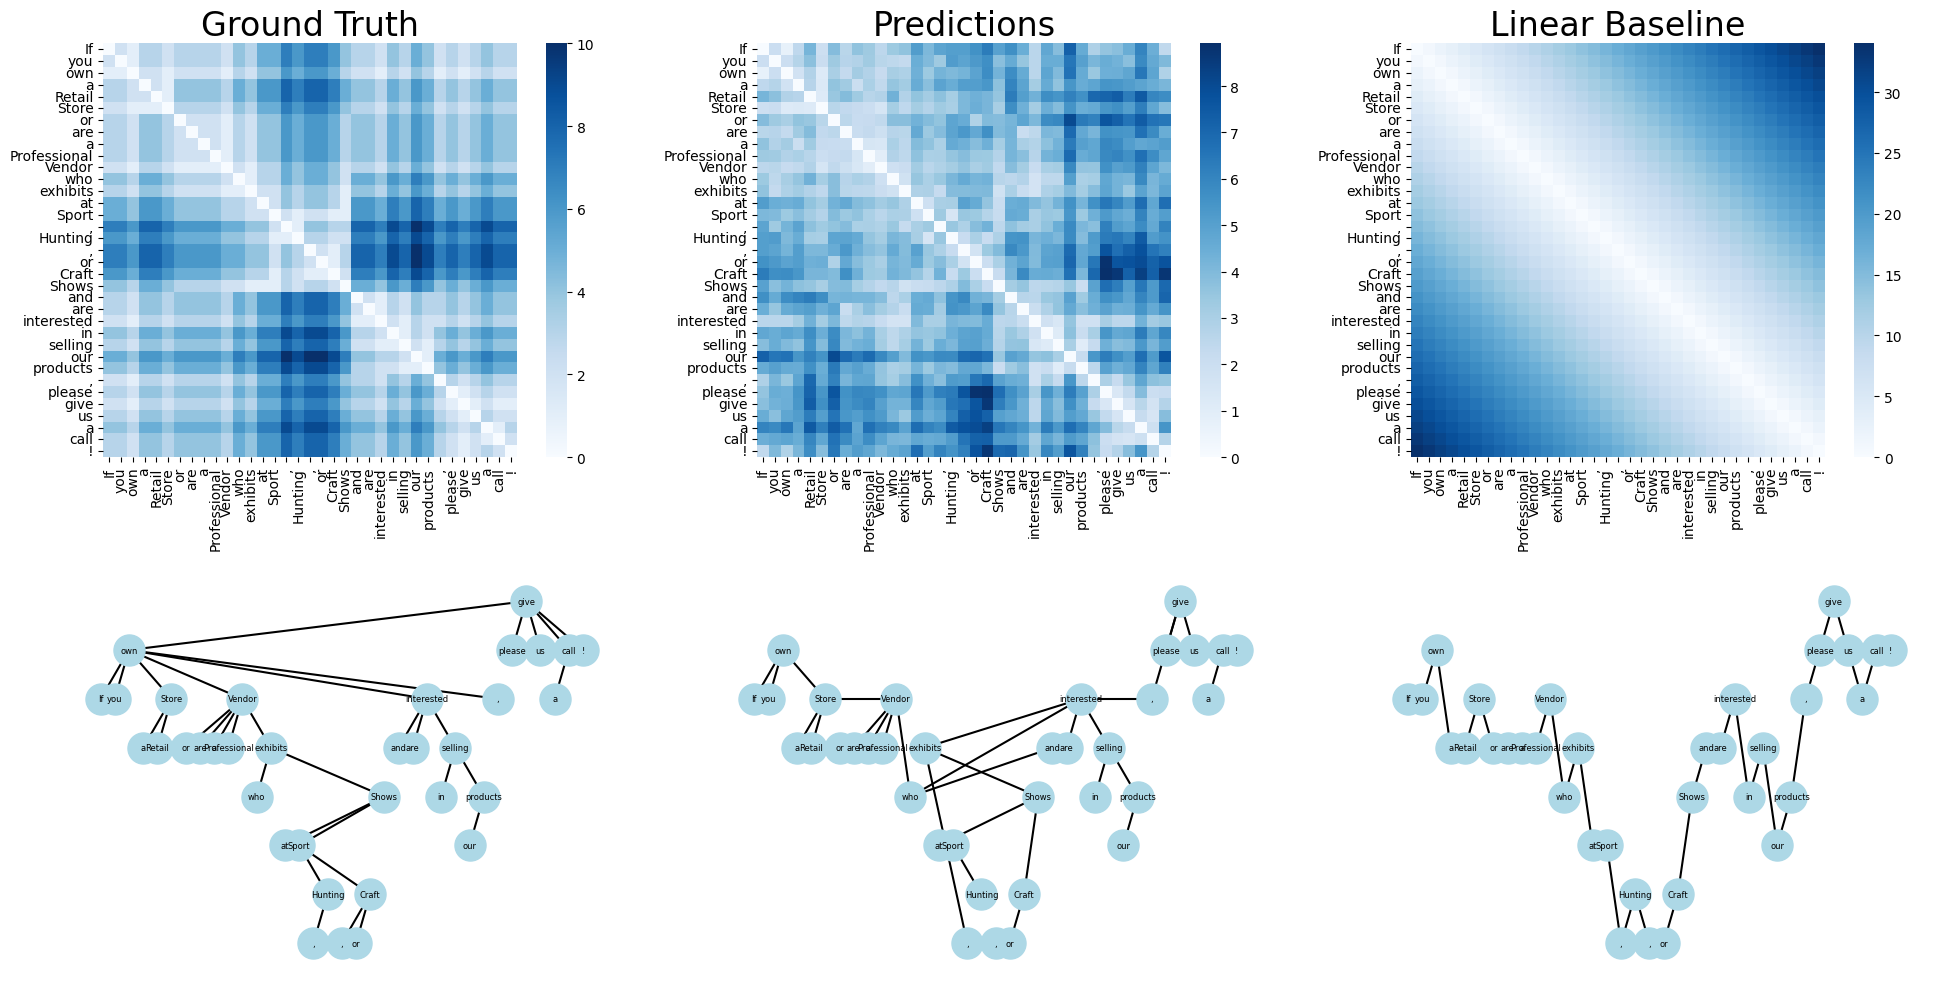

In [65]:
sentence_idx = 778
batch_size = 100
batch_id = sentence_idx // batch_size
idx_in_batch = sentence_idx % batch_size

mat, ids, root_dist, forms = distance_matrix_from_sentence(sentences_test[sentence_idx])
sentence = novel_sentences[sentence_idx]
print(sentence.metadata["text"])

fig, ax = plt.subplots(2, 3, figsize=(20, 10))
# true mat
sns.heatmap(mat, cmap = "Blues", square = True, annot = True if len(sentence) <= 20 else False, xticklabels=forms, yticklabels=forms, ax = ax[0, 0])
# pred mat
sns.heatmap(predictions[batch_id][idx_in_batch][:len(sentence), :len(sentence)],square=True,
            cmap = "Blues", annot = True if len(sentence) <= 20 else False, xticklabels=forms, yticklabels=forms, 
            ax = ax[0, 1])
# baseline mat
sns.heatmap(baseline_mats[sentence_idx][0],square=True,
            cmap = "Blues", annot = True if len(sentence) <= 20 else False, xticklabels=forms, yticklabels=forms, 
            ax = ax[0, 2])

# true graph
graph_from_distance_matrix(mat, ids, root_dist, forms, ax=ax[1, 0], node_size=500, font_size=6, width=1.5)
# pred graph
graph_from_distance_matrix(predictions[batch_id][idx_in_batch][:len(sentence), :len(sentence)], ids, root_dist, forms, ax=ax[1, 1], node_size=500, font_size=6, width=1.5)
# baseline graph
graph_from_distance_matrix(baseline_mats[sentence_idx][0], ids, root_dist, forms, ax=ax[1, 2], node_size=500, font_size=6, width=1.5)

ax[0, 0].set_title("Ground Truth", size = 24)
ax[0, 1].set_title("Predictions", size = 24)
ax[0, 2].set_title("Linear Baseline", size = 24)
plt.tight_layout()

plt.show()

Would love for you to join us.


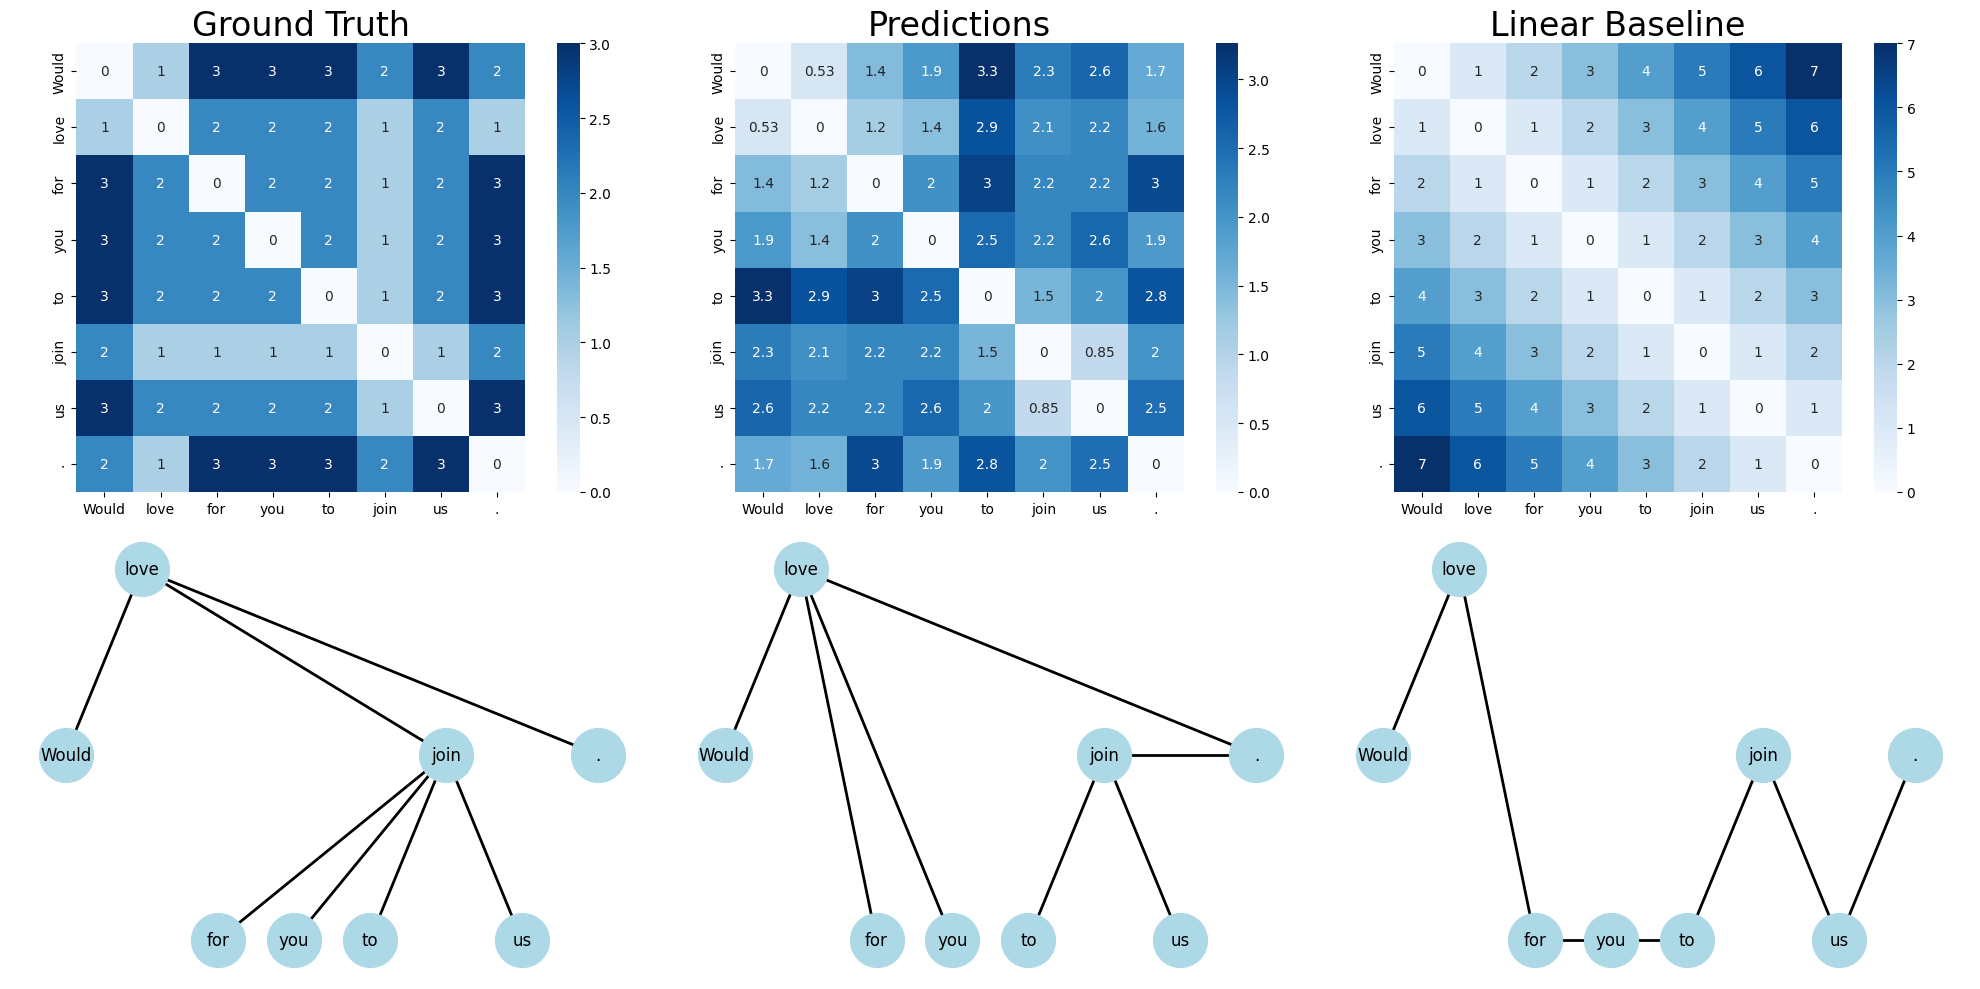

In [99]:
sentence_idx = 410
batch_size = 100
batch_id = sentence_idx // batch_size
idx_in_batch = sentence_idx % batch_size

mat, ids, root_dist, forms = distance_matrix_from_sentence(sentences_test[sentence_idx])
sentence = novel_sentences[sentence_idx]
print(sentence.metadata["text"])

fig, ax = plt.subplots(2, 3, figsize=(20, 10))
sns.heatmap(mat, cmap = "Blues", square = True, annot = True if len(sentence) <= 20 else False, xticklabels=forms, yticklabels=forms, ax = ax[0, 0])
# pred mat
sns.heatmap(predictions[batch_id][idx_in_batch][:len(sentence), :len(sentence)],square=True,
            cmap = "Blues", annot = True if len(sentence) <= 20 else False, xticklabels=forms, yticklabels=forms, 
            ax = ax[0, 1])
# baseline mat
sns.heatmap(baseline_mats[sentence_idx][0],square=True,
            cmap = "Blues", annot = True if len(sentence) <= 20 else False, xticklabels=forms, yticklabels=forms, 
            ax = ax[0, 2])

# true graph
graph_from_distance_matrix(mat, ids, root_dist, forms, ax=ax[1, 0])
# pred graph
graph_from_distance_matrix(predictions[batch_id][idx_in_batch][:len(sentence), :len(sentence)], ids, root_dist, forms, ax=ax[1, 1])
# baseline graph
graph_from_distance_matrix(baseline_mats[sentence_idx][0], ids, root_dist, forms, ax=ax[1, 2])

ax[0, 0].set_title("Ground Truth", size = 24)
ax[0, 1].set_title("Predictions", size = 24)
ax[0, 2].set_title("Linear Baseline", size = 24)
plt.tight_layout()

plt.show()

Now we perform a proper evaluation on the full test set. The function below evaluates the rank-order correlation of the true and predicted distance matrix, as well as the confusion matrix of the resulting adjacency matrix. As trees resulting from the minimum-spanning-tree algorithm are by definition very sparse, we find that raw accuracy and specificity inflates the performance estimate. Therefore, we mainly rely on:

- **Spearman correlation** between true and predicted distance matrix

- **Sensitivity/recall** of edges in the tree

Note that since our predicted tree always has the same number of edges as the true tree, sensitivity/recall (how many true edges are found) and precision (how many of the predicted edges are true) use the same denominator (FN = FP, for each sentence) and therefore end up being equal. Hence, we only report sensitivity/recall.

In [104]:
from scipy.stats import spearmanr
def eval_parse_trees_by_sentence(test_sentences, predictions, batch_size):
    df = pd.DataFrame(columns=['sentence_length', 'TP', 'TN', 'FP', 'FN', 'accuracy', 'sensitivity', 'specificity', 'spearman_rho'])
    for sentence_idx, sentence in enumerate(test_sentences):
        
        batch_id = sentence_idx // batch_size
        idx_in_batch = sentence_idx % batch_size

        mat, ids, root_dist, forms = distance_matrix_from_sentence(sentence)
        n = mat.shape[0]
        m1, _ = graph_from_distance_matrix(mat, ids, root_dist, forms, plot = False)

        pred_mat = predictions[batch_id][idx_in_batch]
        # ensure square and same size
        pred_mat = pred_mat[:n, :n]
        m2, _ = graph_from_distance_matrix(pred_mat, ids, root_dist, forms, plot = False)

        inds = np.triu_indices_from(m1, k=1)
        upper_m1 = m1[inds]
        upper_m2 = m2[inds]

        TP = np.count_nonzero((upper_m1 != 0) & (upper_m2 != 0))
        TN = np.count_nonzero((upper_m1 == 0) & (upper_m2 == 0))
        FP = np.count_nonzero((upper_m1 == 0) & (upper_m2 != 0))
        FN = np.count_nonzero((upper_m1 != 0) & (upper_m2 == 0))
    
        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0 # aka recall
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0 

        inds = np.triu_indices_from(mat, k=1)
        upper_mat = mat[inds]
        upper_pred_mat = pred_mat[inds]

        rho, _ = spearmanr(upper_mat, upper_pred_mat)

        df.loc[sentence_idx] = [n,TP, TN, FP, FN, accuracy, sensitivity, specificity, rho]

    return df

We are also interested in whether our ability to correctly detect an edge depends on the linear distance between word pairs. Therefore, the function below evaluates sensitivity for each level of linear distances (distances >= 10 are binned due to high levels of noise).

In [105]:
def eval_parse_trees_by_depth(test_sentences, predictions, batch_size):
    total_TP = total_TN = total_FP = total_FN = 0

    df = pd.DataFrame(columns=['TP', 'TN', 'FP', 'FN'])

    for sentence_idx, sentence in enumerate(test_sentences):
        batch_id = sentence_idx // batch_size
        idx_in_batch = sentence_idx % batch_size

        mat, ids, root_dist, forms = distance_matrix_from_sentence(sentence)
        n = mat.shape[0]
        m1, _ = graph_from_distance_matrix(mat, ids, root_dist, forms, plot = False)

        pred_mat = predictions[batch_id][idx_in_batch]
        pred_mat = pred_mat[:n, :n]

        m2, _ = graph_from_distance_matrix(pred_mat, ids, root_dist, forms, plot = False)

        inds = np.triu_indices(n, k=1)
        for i, j in zip(inds[0], inds[1]):
            lin_dist = abs(i - j) if abs(i - j) < 10 else 10 # bin all values >= 10 together
            if lin_dist not in df.index:
                df.loc[lin_dist] = [0, 0, 0, 0]

            gold_edge = (m1[i, j] != 0)
            pred_edge = (m2[i, j] != 0)

            if gold_edge and pred_edge:
                total_TP += 1
                df.at[lin_dist, 'TP'] += 1
            elif (not gold_edge) and (not pred_edge):
                total_TN += 1
                df.at[lin_dist, 'TN'] += 1
            elif (not gold_edge) and pred_edge:
                total_FP += 1
                df.at[lin_dist, 'FP'] += 1
            elif gold_edge and (not pred_edge):
                total_FN += 1
                df.at[lin_dist, 'FN'] += 1

    # safe per-distance metrics
    df['accuracy'] = (df['TP'] + df['TN']) / (df['TP'] + df['TN'] + df['FP'] + df['FN'])
    df['sensitivity'] = np.where((df['TP'] + df['FN']) > 0, df['TP'] / (df['TP'] + df['FN']), 0)
    df['specificity'] = np.where((df['TN'] + df['FP']) > 0, df['TN'] / (df['TN'] + df['FP']), 0)
    df = df.fillna(0).sort_index()
    return df

Apply function to both the predicted and linear baseline matrices. We plot a quick barplot in this section, but a more through comparison follows in the Results section below.

In [108]:
# get eval dfs
eval_df_sentence = eval_parse_trees_by_sentence(novel_sentences, predictions, batch_size=100)
eval_df_depth = eval_parse_trees_by_depth(novel_sentences, predictions, batch_size=100)
# get baseline eval dfs
baseline_eval_df_sentence = eval_parse_trees_by_sentence(novel_sentences, baseline_mats, batch_size=1)
baseline_eval_df_depth = eval_parse_trees_by_depth(novel_sentences, baseline_mats, batch_size=1)

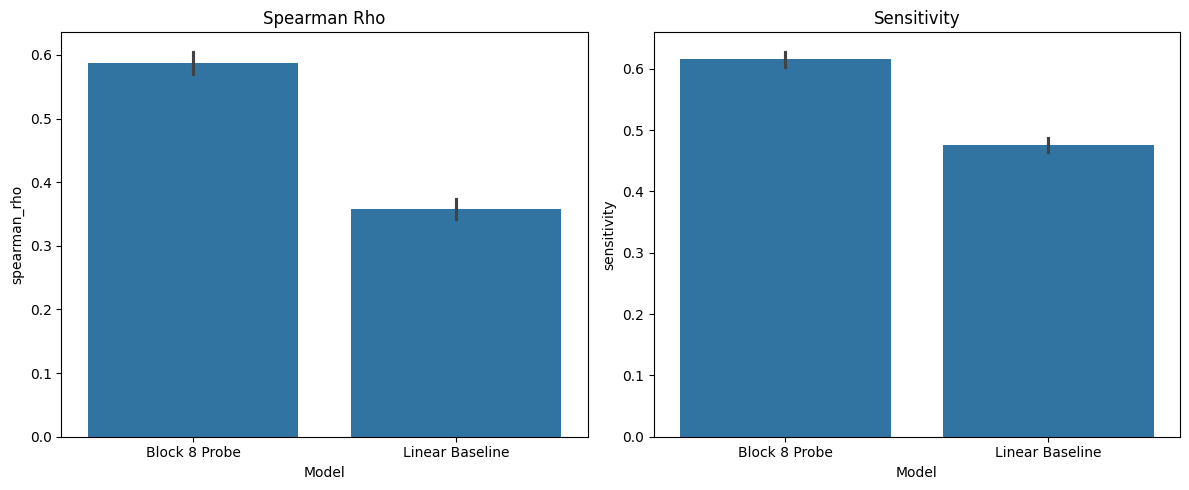

In [120]:
df_plot = pd.concat([eval_df_sentence.reset_index().assign(Model='Block 8 Probe'),
                     baseline_eval_df_sentence.reset_index().assign(Model='Linear Baseline')],
                    ignore_index=True)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(data=df_plot, y='spearman_rho', x='Model', ax=ax[0])
ax[0].set_title('Spearman Rho')
sns.barplot(data=df_plot, y='sensitivity', x='Model', ax=ax[1])
ax[1].set_title('Sensitivity')
plt.tight_layout()
plt.show()

## Scale up to multiple layers

In [ ]:
df_acc = pd.read_pickle('df_acc.pkl')
layer_names = [
    'hook_embed',
    'blocks.0.hook_resid_pre',
    'blocks.0.hook_resid_post', 
    'blocks.2.hook_resid_post', 
    'blocks.4.hook_resid_post',
    'blocks.6.hook_resid_post',
    'blocks.10.hook_resid_post',
    'blocks.11.hook_resid_post'
    ]
for layer_name in layer_names:
    if layer_name in df_acc['layer_name'].values:
        print("skipping layer:", layer_name, " already processed")
        continue
    print(f"Processing layer: {layer_name}")
        
    args = {
        'probe': {'maximum_rank': 64, 'params_path': f'probe_params/{layer_name}_probe_params.pt'},
        'model': {'hidden_dim': 768},
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'probe_training': {'epochs': 50},
        'reporting': {'root': './'}
    }
    probe = TwoWordPSDProbe(args)
    loss_fn = L1DistanceLoss(args)
    regimen = ProbeRegimen(args)

    dataset = SyntaxProbeDataset(sentences_train, 'gpt2-small', layer_name)
    dataloader = DataLoader(dataset, batch_size=32, collate_fn=custom_collate_fn)

    val_dataset = SyntaxProbeDataset(sentences_val, 'gpt2-small', layer_name)
    val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=custom_collate_fn)

    # we use this as the original code assumes feature extraction inside the regimen, while we do so with our custom functions in advance
    class IdentityModel(nn.Module):
        def forward(self, x):
            return x
    model = IdentityModel()

    regimen.train_until_convergence(
        probe=probe,
        model=model,
        loss=loss_fn,
        train_dataset=dataloader,
        dev_dataset=val_dataloader
    )
    
    # Make predictions
    # Prepare new sentences as a SyntaxProbeDataset and DataLoader
    novel_sentences = sentences_test
    novel_dataset = SyntaxProbeDataset(novel_sentences, 'gpt2-small', layer_name)
    novel_dataloader = DataLoader(novel_dataset, batch_size = 100, collate_fn=custom_collate_fn)

    # Make predictions
    predictions = regimen.predict(probe, model, novel_dataloader)

    eval_df_depth = eval_parse_trees_by_depth(test_sentences=novel_sentences, predictions=predictions, batch_size=100)
    eval_df_sentence = eval_parse_trees_by_sentence(novel_sentences, predictions, batch_size=100)
    df_acc.loc[len(df_acc)] = [layer_name, regimen.train_losses, regimen.val_losses, eval_df_depth, eval_df_sentence]
    pd.to_pickle(df_acc, f'df_acc.pkl')


# Results

In [124]:
# load results of full analysis saved earlier
df_eval = pd.read_pickle('df_acc_cleaned.pkl')
# load results of linear baseline
linear_baseline_sentence = pd.read_pickle('linear_baseline_sentence.pkl')
linear_baseline_depth = pd.read_pickle('linear_baseline_depth.pkl')

Evaluate Spearman correlation over layers of GPT-2 small

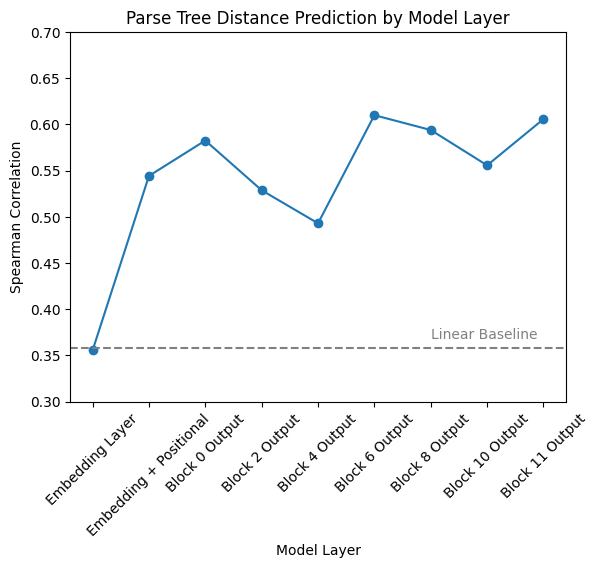

In [126]:
custom_labels = {
    'hook_embed': 'Embedding Layer',
    'blocks.0.hook_resid_pre': 'Embedding + Positional',
    'blocks.0.hook_resid_post': 'Block 0 Output',
    'blocks.2.hook_resid_post': 'Block 2 Output',
    'blocks.4.hook_resid_post': 'Block 4 Output',
    'blocks.6.hook_resid_post': 'Block 6 Output',
    'blocks.8.hook_resid_post': 'Block 8 Output',
    'blocks.10.hook_resid_post': 'Block 10 Output',
    'blocks.11.hook_resid_post': 'Block 11 Output',
    'Linear Baseline': 'Linear Baseline'
}

x_labels = [custom_labels.get(l, l) for l in df_eval['layer_name']]

plt.plot(x_labels, df_eval['eval_df_sentence'].apply(lambda x: x['spearman_rho'].mean()), marker='o', label='Probe')
plt.axhline(
    y=linear_baseline_sentence.mean().loc['spearman_rho'],
    color='grey',
    linestyle='--',
    label=custom_labels['Linear Baseline']
)
plt.ylim(0.3, 0.7)
plt.title('Parse Tree Distance Prediction by Model Layer')
plt.ylabel('Spearman Correlation')
plt.xlabel('Model Layer')
plt.text(
    6,
    linear_baseline_sentence.mean().loc['spearman_rho'] + 0.01,
    custom_labels['Linear Baseline'],
    color='grey'
)
plt.xticks(rotation=45)
plt.show()

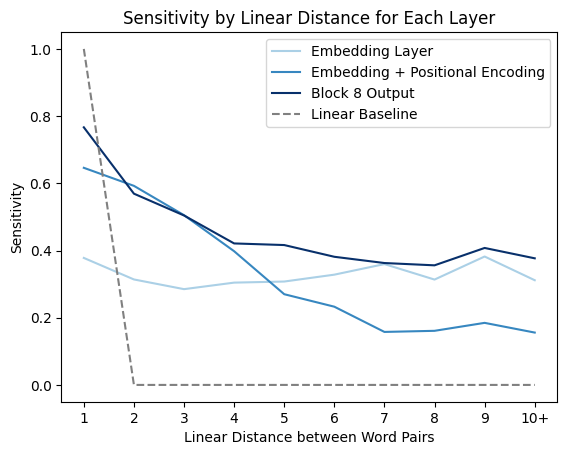

In [136]:
df_plot = df_eval[df_eval['layer_name'].isin(['hook_embed', 'blocks.0.hook_resid_pre', 'blocks.8.hook_resid_post'])]

num_layers = len(df_plot)
cmap = plt.get_cmap('Blues', num_layers + 1)

custom_labels = {
    'hook_embed': 'Embedding Layer',
    'blocks.0.hook_resid_pre': 'Embedding + Positional Encoding',
    'blocks.8.hook_resid_post': 'Block 8 Output',
    'Linear Baseline': 'Linear Baseline'
}

for i in range(num_layers):
    eval_df_depth = df_plot.iloc[i]["eval_df_depth"]
    layer = df_plot.iloc[i]['layer_name']
    label = custom_labels.get(layer, layer)
    plt.plot(
        np.arange(1, 1 + len(eval_df_depth['sensitivity'])),
        eval_df_depth['sensitivity'],
        color=cmap(i + 1),
        label=label
    )
plt.plot(
    linear_baseline_depth["sensitivity"],
    color='grey',
    linestyle='--',
    label=custom_labels['Linear Baseline']
)
plt.xticks(list(range(1, 10)) + [10], labels=[str(i) for i in range(1, 10)] + ["10+"])
plt.xlabel("Linear Distance between Word Pairs")
plt.ylabel("Sensitivity")
plt.title("Sensitivity by Linear Distance for Each Layer")
plt.legend()
plt.show()

## MLP Probe

In [244]:
class MultiLayerProbe(Probe):
    """A multilayer probe using a small MLP."""
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.model_dim = args['model']['hidden_dim']
        self.probe_rank = args['probe']['maximum_rank']
        self.hidden_dim = args['probe'].get('mlp_hidden_dim', 256)
        self.device = args['device']

        self.mlp = nn.Sequential(
            nn.Linear(self.model_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.probe_rank)    
        )
        self.to(self.device)

    def forward(self, batch):
        batch = batch.to(self.device)
        transformed = self.mlp(batch)
        batchlen, seqlen, rank = transformed.size()
        transformed = transformed.unsqueeze(2)
        transformed = transformed.expand(-1, -1, seqlen, -1)
        transposed = transformed.transpose(1, 2)
        diffs = transformed - transposed
        squared_diffs = diffs.pow(2)
        squared_distances = torch.sum(squared_diffs, -1)
        return squared_distances

In [246]:
layer = 'blocks.8.hook_resid_post'

args = {
    'probe': {'maximum_rank': 64, 
              'mlp_hidden_dim': 256,
              'params_path': f'probe_params/multilayer_{layer}_probe_params.pt'},
    'model': {'hidden_dim': 768},
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'probe_training': {'epochs': 50},
    'reporting': {'root': './'}
}
probe_multilayer = MultiLayerProbe(args) ######

loss_fn = L1DistanceLoss(args)
regimen = ProbeRegimen(args)

dataset = SyntaxProbeDataset(sentences_train, 'gpt2-small', layer)
dataloader = DataLoader(dataset, batch_size=32, collate_fn=custom_collate_fn)

val_dataset = SyntaxProbeDataset(sentences_val, 'gpt2-small', layer)
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=custom_collate_fn)

# we use this as the original code assumes feature extraction inside the regimen, while we do so with our custom functions in advance
class IdentityModel(nn.Module):
    def forward(self, x):
        return x
model = IdentityModel()

Loaded pretrained model gpt2-small into HookedTransformer


Processing sentences: 100%|██████████| 9039/9039 [03:55<00:00, 38.45it/s]


Loaded pretrained model gpt2-small into HookedTransformer


Processing sentences: 100%|██████████| 1029/1029 [00:27<00:00, 37.50it/s]


In [247]:
regimen.train_until_convergence(
    probe=probe_multilayer,
    model=model,
    loss=loss_fn,
    train_dataset=dataloader,
    dev_dataset=val_dataloader
)

[training]:   2%|▏         | 1/50 [00:01<01:21,  1.65s/it]

[epoch 0] Train loss: 35.07050449524534, Dev loss: 0.9920710154942104
Saving probe parameters


[training]:   4%|▍         | 2/50 [00:03<01:21,  1.70s/it]

[epoch 1] Train loss: 0.9396982898832436, Dev loss: 0.8976796690530285
Saving probe parameters


[training]:   6%|▌         | 3/50 [00:04<01:17,  1.66s/it]

[epoch 2] Train loss: 0.9465494594791318, Dev loss: 0.9489134917337994


[training]:   8%|▊         | 4/50 [00:06<01:14,  1.61s/it]

[epoch 3] Train loss: 0.7512790584131632, Dev loss: 0.7828940650116946
Saving probe parameters


[training]:  10%|█         | 5/50 [00:08<01:15,  1.68s/it]

[epoch 4] Train loss: 0.737680269957301, Dev loss: 0.7750214756519848
Saving probe parameters


[training]:  12%|█▏        | 6/50 [00:09<01:12,  1.65s/it]

[epoch 5] Train loss: 0.7275758549786996, Dev loss: 0.7669987873155244
Saving probe parameters


[training]:  14%|█▍        | 7/50 [00:11<01:09,  1.62s/it]

[epoch 6] Train loss: 0.7180526023127888, Dev loss: 0.7566183649068671
Saving probe parameters


[training]:  16%|█▌        | 8/50 [00:13<01:07,  1.61s/it]

[epoch 7] Train loss: 0.7081889122879496, Dev loss: 0.7518434640385783
Saving probe parameters


[training]:  18%|█▊        | 9/50 [00:14<01:06,  1.63s/it]

[epoch 8] Train loss: 0.697417891728481, Dev loss: 0.7397684471716107
Saving probe parameters


[training]:  20%|██        | 10/50 [00:16<01:04,  1.61s/it]

[epoch 9] Train loss: 0.6866614706472217, Dev loss: 0.7327150302215961
Saving probe parameters


[training]:  22%|██▏       | 11/50 [00:19<01:19,  2.05s/it]

[epoch 10] Train loss: 0.6764903164025969, Dev loss: 0.7262996199990617
Saving probe parameters


[training]:  24%|██▍       | 12/50 [00:20<01:11,  1.89s/it]

[epoch 11] Train loss: 0.6664185718646526, Dev loss: 0.7158365161588055
Saving probe parameters


[training]:  26%|██▌       | 13/50 [00:23<01:19,  2.16s/it]

[epoch 12] Train loss: 0.6579910199823389, Dev loss: 0.7053983969174044
Saving probe parameters


[training]:  28%|██▊       | 14/50 [00:25<01:16,  2.13s/it]

[epoch 13] Train loss: 0.6452586261265203, Dev loss: 0.700639372316811
Saving probe parameters


[training]:  30%|███       | 15/50 [00:27<01:09,  2.00s/it]

[epoch 14] Train loss: 0.6421013487191152, Dev loss: 0.6937508935251783
Saving probe parameters


[training]:  32%|███▏      | 16/50 [00:29<01:07,  1.97s/it]

[epoch 15] Train loss: 0.6239091542089179, Dev loss: 0.684136549168356
Saving probe parameters


[training]:  34%|███▍      | 17/50 [00:30<01:02,  1.88s/it]

[epoch 16] Train loss: 0.6183086115249109, Dev loss: 0.6790984219086761
Saving probe parameters


[training]:  36%|███▌      | 18/50 [00:32<00:57,  1.81s/it]

[epoch 17] Train loss: 0.610426280914992, Dev loss: 0.6844745768981726


[training]:  38%|███▊      | 19/50 [00:34<00:54,  1.74s/it]

[epoch 18] Train loss: 0.5853958937008437, Dev loss: 0.6606033805276261
Saving probe parameters


[training]:  40%|████      | 20/50 [00:35<00:51,  1.72s/it]

[epoch 19] Train loss: 0.5816488558772075, Dev loss: 0.6600512258049582
Saving probe parameters


[training]:  42%|████▏     | 21/50 [00:37<00:49,  1.69s/it]

[epoch 20] Train loss: 0.5801303653883741, Dev loss: 0.6590118820627878
Saving probe parameters


[training]:  44%|████▍     | 22/50 [00:39<00:47,  1.70s/it]

[epoch 21] Train loss: 0.5783999148479723, Dev loss: 0.6584407011204488
Saving probe parameters


[training]:  46%|████▌     | 23/50 [00:40<00:44,  1.65s/it]

[epoch 22] Train loss: 0.5772085162915148, Dev loss: 0.6571167676163832
Saving probe parameters


[training]:  48%|████▊     | 24/50 [00:42<00:43,  1.66s/it]

[epoch 23] Train loss: 0.5758113106711669, Dev loss: 0.6573515804909872


[training]:  50%|█████     | 25/50 [00:44<00:40,  1.64s/it]

[epoch 24] Train loss: 0.5714970044902975, Dev loss: 0.6550905762423116
Saving probe parameters


[training]:  52%|█████▏    | 26/50 [00:45<00:39,  1.65s/it]

[epoch 25] Train loss: 0.570901378539168, Dev loss: 0.6549245166593205
Saving probe parameters


[training]:  54%|█████▍    | 27/50 [00:47<00:37,  1.62s/it]

[epoch 26] Train loss: 0.5706133514342681, Dev loss: 0.6547229829867912
Saving probe parameters


[training]:  56%|█████▌    | 28/50 [00:48<00:36,  1.64s/it]

[epoch 27] Train loss: 0.5704300865977723, Dev loss: 0.6546675032846434


[training]:  58%|█████▊    | 29/50 [00:50<00:34,  1.64s/it]

[epoch 28] Train loss: 0.5699775348472996, Dev loss: 0.6540220930694491
Saving probe parameters


[training]:  60%|██████    | 30/50 [00:52<00:33,  1.66s/it]

[epoch 29] Train loss: 0.5697384927768414, Dev loss: 0.6539442675917675


[training]:  62%|██████▏   | 31/50 [00:53<00:31,  1.63s/it]

[epoch 30] Train loss: 0.5696773214643014, Dev loss: 0.6538789353403104
Saving probe parameters


[training]:  64%|██████▍   | 32/50 [00:55<00:29,  1.61s/it]

[epoch 31] Train loss: 0.5695355401944898, Dev loss: 0.6538572399447101


[training]:  66%|██████▌   | 33/50 [00:56<00:27,  1.59s/it]

[epoch 32] Train loss: 0.5695077982844604, Dev loss: 0.6538453801843701


[training]:  68%|██████▊   | 34/50 [00:58<00:26,  1.64s/it]

[epoch 33] Train loss: 0.5694961686065232, Dev loss: 0.6538375936977138


[training]:  70%|███████   | 35/50 [01:00<00:24,  1.64s/it]

[epoch 34] Train loss: 0.5694891964654661, Dev loss: 0.6538324439490849


[training]:  70%|███████   | 35/50 [01:01<00:26,  1.77s/it]

[epoch 35] Train loss: 0.5694828619008994, Dev loss: 0.6538265708352433
Early stopping


In [248]:
predictions = regimen.predict(probe_multilayer, model, novel_dataloader)

[predicting]: 100%|██████████| 18/18 [00:00<00:00, 138.36it/s]


In [249]:

eval_df_sentence = eval_parse_trees_by_sentence(novel_sentences, predictions, batch_size=100)
eval_df_sentence.mean()


sentence_length    11.005285
TP                  2.372284
TN                 85.510276
FP                  7.633001
FN                  7.633001
accuracy            0.689790
sensitivity         0.364203
specificity         0.661180
spearman_rho        0.151995
dtype: float64

## Contributions

X did xyz

## References

Hewitt, J., & Manning, C. D. (2019, June). A structural probe for finding syntax in word representations. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 1 (Long and Short Papers) (pp. 4129-4138).

Diego-Simón, P. J., Chemla, E., King, J. R., & Lakretz, Y. (2025). Probing syntax in large language models: Successes and remaining challenges. arXiv preprint arXiv:2508.03211.